In [43]:
import os
import cv2
import numpy as np
from pathlib import Path
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer, Reshape, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from sklearn.metrics import  confusion_matrix,precision_score,accuracy_score,recall_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
import pandas as pd

In [44]:
URL="./Videos"


In [45]:
metricas={"precision":[],"recall":[]}

## Funciones definidas

In [46]:
def obtenerDatos(archivo):
   data=h5py.File(archivo)
   return data["X"][:],data["Y"][:] 

In [47]:
def obtener_etiquetas(url):
    labels=[]
    for index,carpeta in enumerate(os.listdir(str(url))):
        labels.append(carpeta)
    return labels

In [ ]:
def normalizar(X):
    X_normalizado = X.copy()
    for canal in range(X.shape[2]):  
        X_normalizado[:, :, canal] = (X[:, :, canal] - X[:, :, canal].min()) / (X[:, :, canal].max() - X    [:, :, canal].min())
    return X_normalizado


In [49]:
def redimensionarData(X,ancho,largo):
    imagenes=[]
    for imagen in X:
        imagenes.append(cv2.resize(imagen, (ancho, largo), interpolation=cv2.INTER_AREA))
    return np.array(imagenes)


In [50]:
def redimensionarDataYVolverRGB(X,ancho,largo):
    imagenes=[]
    for imagen in X:
        imagenes.append(cv2.cvtColor(cv2.resize(imagen, (ancho, largo), interpolation=cv2.INTER_AREA),cv2.COLOR_BGR2RGB))
    return np.array(imagenes)

In [51]:
def graficarHistorialEntrenamiento(historial):
    plt.plot(historial.history["loss"],label="costo")
    plt.plot(historial.history["val_loss"],label="costo_data_val")
    plt.plot(historial.history["accuracy"],label="precision")
    plt.plot(historial.history["val_accuracy"],label="precision_data_val")
    plt.xlabel("Epoca")
    plt.legend()
    plt.title('Evolución de la pérdida en el entrenamiento')
    plt.show()

In [52]:
def graficarMatrizDeConfusion(y_test,y_pred,labels):
    modeloCM=confusion_matrix(y_test,y_pred)
    cm=ConfusionMatrixDisplay(modeloCM,display_labels=labels)
    cm.plot()

In [53]:
def get_metricasModelo(df,y_test,y_pred):
    precision=precision_score(y_test,y_pred,average="macro")
    recall=recall_score(y_test,y_pred,average="macro")
    df["precision"].append(precision)
    df["recall"].append(recall)
    return df


In [54]:
def plot_image(image):
    plt.imshow(image, cmap = "gray", interpolation = "nearest")
    plt.axis("off")

## Cargamos los datos

In [55]:
X_train,y_train=obtenerDatos("./data/datos_train.h5")


In [56]:
X_test,y_test=obtenerDatos("./data/datos_test.h5")


In [57]:
X_train.shape

(2400, 40000)

In [58]:
y_train.shape

(2400,)

In [59]:
X_test.shape

(800, 40000)

In [60]:
y_test.shape

(800,)

## Visualizamos la data

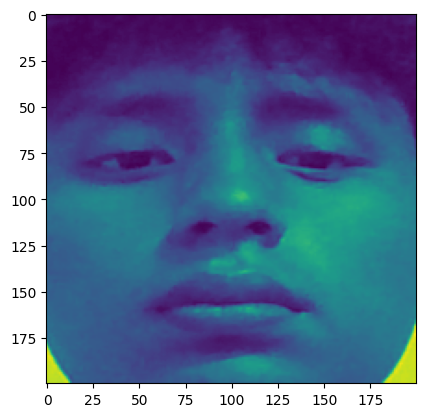

In [61]:
plt.imshow(X_train[12].reshape(200,200))

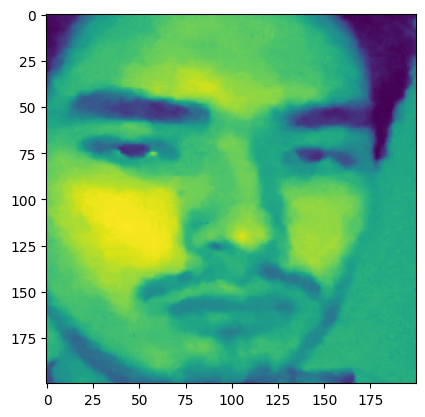

In [62]:
plt.imshow(X_train[2000].reshape(200,200))

In [63]:
labels=['Agus', 'Ale', 'Noni', 'Sebas']

In [64]:
labels

['Agus', 'Ale', 'Noni', 'Sebas']

In [65]:
X_train_copia=X_train.copy()
X_test_copia=X_test.copy()


In [66]:
y_train_copia=y_train.copy()
y_test_copia=y_test.copy()

In [67]:
X_train_copia=redimensionarData(X_train_copia,160,160)
X_test_copia=redimensionarData(X_test_copia,160,160)


X_train_copia=normalizar(X_train_copia)
X_test_copia=normalizar(X_test_copia)

In [68]:
X_train_copia=np.array([foto.flatten() for foto in X_train_copia])
X_test_copia=np.array([foto.flatten() for foto in X_test_copia])


In [69]:
X_train_copia.shape

(2400, 25600)

In [70]:
X_test_copia.shape

(800, 25600)

In [71]:
class ModeloPersonalizado:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.modelo = None
        self.historial = None
        self.predicciones = None
        self.matriz_confusion = None

    def construir_modelo(self, configuracion):
        self.modelo = Sequential()
        self.modelo.add(InputLayer(input_shape=(self.input_dim,)))

        for capa in configuracion["capas_ocultas"]:
            self.modelo.add(Dense(capa["neuronas"], activation=capa["activation"]))
            if "dropout" in capa and capa["dropout"] > 0:
                self.modelo.add(Dropout(capa["dropout"]))

        self.modelo.add(Dense(self.output_dim, activation="softmax"))

    def compilar_modelo(self, learning_rate):
        optimizer = Nadam(learning_rate=learning_rate)
        self.modelo.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    def entrenar_modelo(self, X_train, y_train, X_val, y_val, epochs, factor_reduccion, paciencia):
        """
        Un callback en Keras es un conjunto de funciones que puedes usar para personalizar y controlar el proceso de entrenamiento del modelo
        ReduceLROnPlateau es un callback en Keras que se utiliza para reducir la tasa de aprendizaje (learning rate)
        automáticamente si una métrica(val_loss) no mejora después de un número definido de épocas (patience).
        min_lr:El learning rate no se reducirá por debajo de este valor, lo que previene que se acerque a cero.
        lr_scheduler=planificador de la tasa de aprendizaje

        Todo este trabajo se hace poruqe la tasa de aprendizaje se encarga de enontrar el j mas pequeno para los thetas
        si este j o en nuestro caso el val_loss ya no baja mucho o de la nada se subio su valor que posiblemente estemos cerca al mejor
        j o val_loss posible para los tethas y nos conviende dar pasitos mas cortos en la tasa de aprendizaje cuidando de que no sea cero con 
        min_lr
        """
        lr_scheduler = ReduceLROnPlateau(
            monitor="val_loss",
            factor=factor_reduccion,
            patience=paciencia,
            verbose=1,
            min_lr=1e-6
        )

        self.historial = self.modelo.fit(
            X_train, 
            y_train, 
            epochs=epochs, 
            validation_data=(X_val, y_val), 
            callbacks=[lr_scheduler], 
            verbose=1
        )

    def evaluar_modelo(self, X_test, y_test, labels, configuracion):
        probabilidades = self.modelo.predict(X_test)
        self.predicciones = np.argmax(probabilidades, axis=1)

        #El macro average calcula la precisión y el recall de forma independiente para cada clase. Luego toma el promedio aritmético de esas métricas.
        precision = precision_score(y_test, self.predicciones, average="macro")
        recall = recall_score(y_test, self.predicciones, average="macro")

        self.matriz_confusion = confusion_matrix(y_test, self.predicciones)

        resultados = {
            "configuracion": configuracion,
            "precision": precision,
            "recall": recall,
            "historial": self.historial.history,
            "matriz_confusion": self.matriz_confusion
        }

        return resultados

In [73]:
configuraciones = [
    # Etapa 1: 
    {
        "capas_ocultas": [{"neuronas": 32, "activation": "relu", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 32, "activation": "tanh", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 32, "activation": "leaky_relu", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 32, "activation": "swish", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 64, "activation": "relu", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 64, "activation": "tanh", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 64, "activation": "leaky_relu", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 64, "activation": "swish", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 128, "activation": "relu", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 128, "activation": "tanh", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 128, "activation": "leaky_relu", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 128, "activation": "swish", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 256, "activation": "relu", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 256, "activation": "tanh", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 256, "activation": "leaky_relu", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 256, "activation": "swish", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    
    # Etapa 2: 
    {
        "capas_ocultas": [
            {"neuronas": 128, "activation": "relu", "dropout": 0.2},
            {"neuronas": 64, "activation": "relu", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 128, "activation": "leaky_relu", "dropout": 0.2},
            {"neuronas": 64, "activation": "leaky_relu", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 128, "activation": "swish", "dropout": 0.2},
            {"neuronas": 64, "activation": "swish", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 150, "activation": "relu", "dropout": 0.25},
            {"neuronas": 75, "activation": "relu", "dropout": 0.25},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 150, "activation": "leaky_relu", "dropout": 0.25},
            {"neuronas": 75, "activation": "leaky_relu", "dropout": 0.25},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 150, "activation": "swish", "dropout": 0.25},
            {"neuronas": 75, "activation": "swish", "dropout": 0.25},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 256, "activation": "relu", "dropout": 0.3},
            {"neuronas": 128, "activation": "relu", "dropout": 0.3},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 256, "activation": "leaky_relu", "dropout": 0.3},
            {"neuronas": 128, "activation": "leaky_relu", "dropout": 0.3},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 256, "activation": "swish", "dropout": 0.3},
            {"neuronas": 128, "activation": "swish", "dropout": 0.3},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },

    # Etapa 3: 
    {
        "capas_ocultas": [
            {"neuronas": 150, "activation": "relu", "dropout": 0.2},
            {"neuronas": 100, "activation": "relu", "dropout": 0.2},
            {"neuronas": 50, "activation": "relu", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 150, "activation": "leaky_relu", "dropout": 0.2},
            {"neuronas": 100, "activation": "leaky_relu", "dropout": 0.2},
            {"neuronas": 50, "activation": "leaky_relu", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 150, "activation": "swish", "dropout": 0.2},
            {"neuronas": 100, "activation": "swish", "dropout": 0.2},
            {"neuronas": 50, "activation": "swish", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 256, "activation": "relu", "dropout": 0.3},
            {"neuronas": 128, "activation": "relu", "dropout": 0.3},
            {"neuronas": 64, "activation": "relu", "dropout": 0.3},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 256, "activation": "leaky_relu", "dropout": 0.3},
            {"neuronas": 128, "activation": "leaky_relu", "dropout": 0.3},
            {"neuronas": 64, "activation": "leaky_relu", "dropout": 0.3},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 256, "activation": "swish", "dropout": 0.3},
            {"neuronas": 128, "activation": "swish", "dropout": 0.3},
            {"neuronas": 64, "activation": "swish", "dropout": 0.3},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 512, "activation": "relu", "dropout": 0.3},
            {"neuronas": 256, "activation": "relu", "dropout": 0.3},
            {"neuronas": 128, "activation": "relu", "dropout": 0.3},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 512, "activation": "leaky_relu", "dropout": 0.3},
            {"neuronas": 256, "activation": "leaky_relu", "dropout": 0.3},
            {"neuronas": 128, "activation": "leaky_relu", "dropout": 0.3},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 512, "activation": "swish", "dropout": 0.3},
            {"neuronas": 256, "activation": "swish", "dropout": 0.3},
            {"neuronas": 128, "activation": "swish", "dropout": 0.3},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    }
]

resultados_metricas = []

for idx, config in enumerate(configuraciones):
    print(f"Entrenando modelo {idx + 1}/{len(configuraciones)}...")

    modelo = ModeloPersonalizado(input_dim=25600, output_dim=4)
    modelo.construir_modelo(config)
    modelo.compilar_modelo(learning_rate=config["learning_rate"])
    modelo.entrenar_modelo(
        X_train=X_train_copia,
        y_train=y_train,
        X_val=X_test_copia,
        y_val=y_test,
        epochs=50,
        factor_reduccion=config["factor_reduccion"],
        paciencia=5,
    )
    
    resultados = modelo.evaluar_modelo(
        X_test=X_test_copia,
        y_test=y_test,
        labels=labels,
        configuracion=config
    )
    resultados_metricas.append(resultados)

    print(f"Modelo {idx + 1} se acabo de entrenar y se guardo")

df_resultados = pd.DataFrame(resultados_metricas)


Entrenando modelo 1/34...
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5585 - loss: 1.8742 - val_accuracy: 0.4850 - val_loss: 2.6730 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9258 - loss: 0.2256 - val_accuracy: 0.4963 - val_loss: 2.4524 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9423 - loss: 0.1762 - val_accuracy: 0.5587 - val_loss: 2.6100 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9634 - loss: 0.1242 - val_accuracy: 0.4600 - val_loss: 2.3786 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9623 - loss: 0.1253 - val_accuracy: 0.4688 - val_loss: 2.7445 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9642 - loss: 0.1232 - val_accuracy: 0.4700 - val_loss: 2.9443 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9664 - lo

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2475 - loss: 3.9103 - val_accuracy: 0.2500 - val_loss: 2.3278 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2446 - loss: 2.1446 - val_accuracy: 0.2500 - val_loss: 1.5241 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2422 - loss: 1.5230 - val_accuracy: 0.2500 - val_loss: 1.3866 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2407 - loss: 1.4517 - val_accuracy: 0.2500 - val_loss: 1.3866 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2476 - loss: 1.4312 - val_accuracy: 0.2500 - val_loss: 1.3869 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2504 - loss: 1.4406 - val_accuracy: 0.2500 - val_loss: 1.3880 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2763 - loss: 1.4253 - val_accuracy: 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6474 - loss: 2.5098 - val_accuracy: 0.5713 - val_loss: 2.8255 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9651 - loss: 0.1205 - val_accuracy: 0.5950 - val_loss: 2.2689 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9761 - loss: 0.0810 - val_accuracy: 0.5888 - val_loss: 2.6276 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9910 - loss: 0.0414 - val_accuracy: 0.5638 - val_loss: 2.9223 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9894 - loss: 0.0389 - val_accuracy: 0.5150 - val_loss: 3.6786 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9942 - loss: 0.0292 - val_accuracy: 0.6100 - val_loss: 2.3059 - learning_rate: 0.0010
Epoch 7/50
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9924 - loss: 0.0346
Epoch 7: ReduceL

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6712 - loss: 2.4726 - val_accuracy: 0.5575 - val_loss: 2.1257 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9752 - loss: 0.1018 - val_accuracy: 0.5500 - val_loss: 2.4263 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9802 - loss: 0.0777 - val_accuracy: 0.5375 - val_loss: 2.4571 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9833 - loss: 0.0628 - val_accuracy: 0.6012 - val_loss: 1.8840 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9754 - loss: 0.0834 - val_accuracy: 0.5250 - val_loss: 2.0816 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9879 - loss: 0.0514 - val_accuracy: 0.5537 - val_loss: 2.2406 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9864 - loss: 0.0435 - val_accuracy: 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6011 - loss: 1.6533 - val_accuracy: 0.5175 - val_loss: 2.6064 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9453 - loss: 0.1976 - val_accuracy: 0.5775 - val_loss: 2.7037 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9595 - loss: 0.1337 - val_accuracy: 0.5437 - val_loss: 2.7670 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9727 - loss: 0.1014 - val_accuracy: 0.5913 - val_loss: 2.6385 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9760 - loss: 0.0926 - val_accuracy: 0.5562 - val_loss: 2.5855 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9834 - loss: 0.0640 - val_accuracy: 0.5663 - val_loss: 2.9040 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9845 - loss: 0.0605 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3039 - loss: 4.0388 - val_accuracy: 0.2500 - val_loss: 1.7811 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3951 - loss: 1.3984 - val_accuracy: 0.0925 - val_loss: 1.4883 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4547 - loss: 1.1905 - val_accuracy: 0.2087 - val_loss: 1.5136 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4664 - loss: 1.1493 - val_accuracy: 0.2500 - val_loss: 1.5149 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4947 - loss: 1.1027 - val_accuracy: 0.2500 - val_loss: 1.5117 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4701 - loss: 1.0681 - val_accuracy: 0.2500 - val_loss: 1.6554 - learning_rate: 0.0010
Epoch 7/50
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4735 - loss: 1.0639
Epoch 7: 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6812 - loss: 4.6324 - val_accuracy: 0.5525 - val_loss: 2.6663 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9706 - loss: 0.1063 - val_accuracy: 0.5900 - val_loss: 3.7259 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9815 - loss: 0.0684 - val_accuracy: 0.6325 - val_loss: 3.3052 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9898 - loss: 0.0397 - val_accuracy: 0.6162 - val_loss: 2.8979 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9801 - loss: 0.0682 - val_accuracy: 0.4950 - val_loss: 4.5571 - learning_rate: 0.0010
Epoch 6/50
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9903 - loss: 0.0389
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9900 - loss: 0.0398 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6553 - loss: 3.4864 - val_accuracy: 0.5888 - val_loss: 2.6778 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9686 - loss: 0.1445 - val_accuracy: 0.5188 - val_loss: 2.9399 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9727 - loss: 0.1048 - val_accuracy: 0.6363 - val_loss: 2.6024 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9801 - loss: 0.0746 - val_accuracy: 0.5663 - val_loss: 2.6632 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9888 - loss: 0.0590 - val_accuracy: 0.6100 - val_loss: 2.3993 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9843 - loss: 0.0583 - val_accuracy: 0.6100 - val_loss: 3.1210 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9898 - loss: 0.0375 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6151 - loss: 3.9891 - val_accuracy: 0.5975 - val_loss: 4.3841 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9728 - loss: 0.1176 - val_accuracy: 0.6250 - val_loss: 4.1032 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9863 - loss: 0.0713 - val_accuracy: 0.5713 - val_loss: 3.7098 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9831 - loss: 0.0693 - val_accuracy: 0.5713 - val_loss: 3.2282 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9874 - loss: 0.0582 - val_accuracy: 0.4663 - val_loss: 2.3340 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9920 - loss: 0.0410 - val_accuracy: 0.4812 - val_loss: 4.3345 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9913 - loss: 0.0381 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2708 - loss: 3.4719 - val_accuracy: 0.2900 - val_loss: 1.3611 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2892 - loss: 1.4110 - val_accuracy: 0.2500 - val_loss: 1.2672 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3956 - loss: 1.2604 - val_accuracy: 0.3212 - val_loss: 1.2685 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4341 - loss: 1.1507 - val_accuracy: 0.5000 - val_loss: 1.2891 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4442 - loss: 1.1168 - val_accuracy: 0.2500 - val_loss: 1.2985 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4774 - loss: 1.0516 - val_accuracy: 0.5038 - val_loss: 1.2102 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4856 - loss: 1.0079 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6644 - loss: 7.0245 - val_accuracy: 0.5700 - val_loss: 2.5778 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9690 - loss: 0.1151 - val_accuracy: 0.5163 - val_loss: 3.3871 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9684 - loss: 0.1142 - val_accuracy: 0.6488 - val_loss: 6.1601 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9722 - loss: 0.1110 - val_accuracy: 0.6137 - val_loss: 6.0186 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9814 - loss: 0.0738 - val_accuracy: 0.5600 - val_loss: 4.9889 - learning_rate: 0.0010
Epoch 6/50
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9824 - loss: 0.0662
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9824 - loss: 0.0661 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6466 - loss: 4.7064 - val_accuracy: 0.5362 - val_loss: 3.1088 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9867 - loss: 0.0621 - val_accuracy: 0.5587 - val_loss: 2.6077 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9871 - loss: 0.0643 - val_accuracy: 0.5487 - val_loss: 3.6173 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 406s 5s/step - accuracy: 0.9922 - loss: 0.0369 - val_accuracy: 0.5863 - val_loss: 3.6235 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9864 - loss: 0.0444 - val_accuracy: 0.5950 - val_loss: 3.8895 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9851 - loss: 0.0545 - val_accuracy: 0.5312 - val_loss: 2.4619 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9926 - loss: 0.0283 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6583 - loss: 4.2140 - val_accuracy: 0.5550 - val_loss: 3.6769 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9888 - loss: 0.0589 - val_accuracy: 0.4812 - val_loss: 3.5336 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9886 - loss: 0.0492 - val_accuracy: 0.5562 - val_loss: 2.6188 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9913 - loss: 0.0436 - val_accuracy: 0.4688 - val_loss: 2.9502 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9919 - loss: 0.0319 - val_accuracy: 0.6025 - val_loss: 3.0269 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9949 - loss: 0.0282 - val_accuracy: 0.5275 - val_loss: 2.7900 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9918 - loss: 0.0362 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.3095 - loss: 4.0419 - val_accuracy: 0.4263 - val_loss: 1.2849 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5662 - loss: 1.0254 - val_accuracy: 0.4462 - val_loss: 1.2954 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6678 - loss: 0.8790 - val_accuracy: 0.6275 - val_loss: 1.2856 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7651 - loss: 0.7371 - val_accuracy: 0.4863 - val_loss: 1.3166 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8235 - loss: 0.6263 - val_accuracy: 0.5788 - val_loss: 1.3647 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8697 - loss: 0.5277 - val_accuracy: 0.6162 - val_loss: 1.1249 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8884 - loss: 0.4694 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6339 - loss: 9.2371 - val_accuracy: 0.5688 - val_loss: 4.1214 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9680 - loss: 0.1477 - val_accuracy: 0.5025 - val_loss: 6.5419 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9719 - loss: 0.1005 - val_accuracy: 0.5487 - val_loss: 4.8780 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9636 - loss: 0.1220 - val_accuracy: 0.4650 - val_loss: 6.2462 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9735 - loss: 0.0976 - val_accuracy: 0.6037 - val_loss: 7.0271 - learning_rate: 0.0010
Epoch 6/50
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9650 - loss: 0.1633
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9650 - loss: 0.1637 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6389 - loss: 6.3602 - val_accuracy: 0.5175 - val_loss: 2.7879 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9801 - loss: 0.0862 - val_accuracy: 0.5675 - val_loss: 3.6795 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9866 - loss: 0.0570 - val_accuracy: 0.5850 - val_loss: 2.3524 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9856 - loss: 0.0571 - val_accuracy: 0.5487 - val_loss: 4.5061 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9884 - loss: 0.0421 - val_accuracy: 0.4750 - val_loss: 4.2340 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9910 - loss: 0.0324 - val_accuracy: 0.4875 - val_loss: 2.4032 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9938 - loss: 0.0279 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4906 - loss: 2.7492 - val_accuracy: 0.5450 - val_loss: 1.3207 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9156 - loss: 0.2761 - val_accuracy: 0.4900 - val_loss: 2.1243 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9458 - loss: 0.1741 - val_accuracy: 0.5850 - val_loss: 1.7924 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9619 - loss: 0.1240 - val_accuracy: 0.5713 - val_loss: 2.4434 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9691 - loss: 0.0844 - val_accuracy: 0.5475 - val_loss: 2.3144 - learning_rate: 0.0010
Epoch 6/50
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9710 - loss: 0.0861
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9709 - loss: 0.0866 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5508 - loss: 3.4901 - val_accuracy: 0.5138 - val_loss: 3.1303 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9404 - loss: 0.2057 - val_accuracy: 0.5088 - val_loss: 4.6845 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9548 - loss: 0.1462 - val_accuracy: 0.4963 - val_loss: 3.6034 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9547 - loss: 0.1552 - val_accuracy: 0.4825 - val_loss: 4.3397 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9636 - loss: 0.1450 - val_accuracy: 0.4613 - val_loss: 7.2268 - learning_rate: 0.0010
Epoch 6/50
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9582 - loss: 0.1321
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9587 - loss: 0.1310 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5672 - loss: 2.1566 - val_accuracy: 0.5088 - val_loss: 2.6043 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9583 - loss: 0.1504 - val_accuracy: 0.5888 - val_loss: 2.7541 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9636 - loss: 0.1228 - val_accuracy: 0.4613 - val_loss: 2.9641 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9764 - loss: 0.0839 - val_accuracy: 0.5300 - val_loss: 2.5296 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9681 - loss: 0.1041 - val_accuracy: 0.4575 - val_loss: 2.4457 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9724 - loss: 0.0857 - val_accuracy: 0.4750 - val_loss: 2.5684 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9591 - loss: 0.0928 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5050 - loss: 2.5414 - val_accuracy: 0.6062 - val_loss: 1.3455 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9177 - loss: 0.2471 - val_accuracy: 0.5213 - val_loss: 1.5554 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9318 - loss: 0.2133 - val_accuracy: 0.5500 - val_loss: 2.1089 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9544 - loss: 0.1375 - val_accuracy: 0.5638 - val_loss: 1.5331 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9505 - loss: 0.1631 - val_accuracy: 0.6137 - val_loss: 1.6620 - learning_rate: 0.0010
Epoch 6/50
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9673 - loss: 0.0946
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9668 - loss: 0.0955 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5562 - loss: 3.4766 - val_accuracy: 0.6012 - val_loss: 3.6102 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9296 - loss: 0.2816 - val_accuracy: 0.5000 - val_loss: 4.3468 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9416 - loss: 0.2546 - val_accuracy: 0.5100 - val_loss: 6.0518 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9539 - loss: 0.1894 - val_accuracy: 0.6037 - val_loss: 6.9428 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9653 - loss: 0.1430 - val_accuracy: 0.6538 - val_loss: 6.3548 - learning_rate: 0.0010
Epoch 6/50
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9674 - loss: 0.1160
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9673 - loss: 0.1166 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5236 - loss: 3.3795 - val_accuracy: 0.4950 - val_loss: 1.8057 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9207 - loss: 0.2568 - val_accuracy: 0.5950 - val_loss: 1.5702 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9559 - loss: 0.1274 - val_accuracy: 0.6200 - val_loss: 1.7610 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9536 - loss: 0.1590 - val_accuracy: 0.4500 - val_loss: 2.9444 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9519 - loss: 0.1363 - val_accuracy: 0.6212 - val_loss: 1.2986 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9658 - loss: 0.1004 - val_accuracy: 0.5138 - val_loss: 3.2269 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9672 - loss: 0.1257 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.5223 - loss: 2.5778 - val_accuracy: 0.4863 - val_loss: 2.2868 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9296 - loss: 0.2453 - val_accuracy: 0.5387 - val_loss: 1.5918 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9458 - loss: 0.1893 - val_accuracy: 0.5950 - val_loss: 2.3133 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9661 - loss: 0.1157 - val_accuracy: 0.5725 - val_loss: 1.9226 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9642 - loss: 0.1130 - val_accuracy: 0.6463 - val_loss: 2.2832 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9578 - loss: 0.1176 - val_accuracy: 0.6150 - val_loss: 2.5983 - learning_rate: 0.0010
Epoch 7/50
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9699 - loss: 0.0908
Epoch 7: 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5443 - loss: 7.3269 - val_accuracy: 0.5213 - val_loss: 4.2824 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9155 - loss: 0.3252 - val_accuracy: 0.5013 - val_loss: 7.1339 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9182 - loss: 0.3611 - val_accuracy: 0.5738 - val_loss: 4.7481 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9478 - loss: 0.2338 - val_accuracy: 0.5063 - val_loss: 4.5261 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9494 - loss: 0.2361 - val_accuracy: 0.4750 - val_loss: 7.2748 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9613 - loss: 0.2275
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9613 - loss: 0.2275 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5435 - loss: 4.1126 - val_accuracy: 0.5238 - val_loss: 2.9127 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9356 - loss: 0.2131 - val_accuracy: 0.6450 - val_loss: 2.0999 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9570 - loss: 0.1416 - val_accuracy: 0.5188 - val_loss: 2.8336 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9558 - loss: 0.1451 - val_accuracy: 0.6288 - val_loss: 3.3637 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9687 - loss: 0.1021 - val_accuracy: 0.5562 - val_loss: 2.1054 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9551 - loss: 0.1272 - val_accuracy: 0.5213 - val_loss: 2.0758 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9601 - loss: 0.1203 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4681 - loss: 1.8307 - val_accuracy: 0.5188 - val_loss: 2.0286 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9071 - loss: 0.2714 - val_accuracy: 0.6137 - val_loss: 1.3553 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9446 - loss: 0.1805 - val_accuracy: 0.6175 - val_loss: 1.5993 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9562 - loss: 0.1303 - val_accuracy: 0.6363 - val_loss: 1.9772 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9600 - loss: 0.1168 - val_accuracy: 0.6000 - val_loss: 2.0189 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9556 - loss: 0.1188 - val_accuracy: 0.5113 - val_loss: 3.7015 - learning_rate: 0.0010
Epoch 7/50
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9579 - loss: 0.1506
Epoch 7: 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5054 - loss: 3.4427 - val_accuracy: 0.4775 - val_loss: 2.5381 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9169 - loss: 0.2608 - val_accuracy: 0.5575 - val_loss: 3.0432 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9439 - loss: 0.2165 - val_accuracy: 0.5462 - val_loss: 2.7867 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 333ms/step - accuracy: 0.9657 - loss: 0.1206 - val_accuracy: 0.4812 - val_loss: 3.3026 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9625 - loss: 0.1337 - val_accuracy: 0.5800 - val_loss: 3.9341 - learning_rate: 0.0010
Epoch 6/50
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9615 - loss: 0.1428
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9615 - loss: 0.1431 - val_a

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.4760 - loss: 2.7246 - val_accuracy: 0.5088 - val_loss: 1.8855 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9339 - loss: 0.2544 - val_accuracy: 0.4638 - val_loss: 2.9066 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9428 - loss: 0.2184 - val_accuracy: 0.4400 - val_loss: 2.5057 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9510 - loss: 0.1590 - val_accuracy: 0.5400 - val_loss: 2.7670 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9657 - loss: 0.1120 - val_accuracy: 0.5275 - val_loss: 2.4547 - learning_rate: 0.0010
Epoch 6/50
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9613 - loss: 0.1046
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9614 - loss: 0.1043 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.4304 - loss: 2.7467 - val_accuracy: 0.4663 - val_loss: 2.5763 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8947 - loss: 0.3433 - val_accuracy: 0.4812 - val_loss: 2.3502 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9222 - loss: 0.2383 - val_accuracy: 0.6087 - val_loss: 1.9671 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9222 - loss: 0.1990 - val_accuracy: 0.6212 - val_loss: 1.1316 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9251 - loss: 0.2543 - val_accuracy: 0.6837 - val_loss: 1.1985 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9214 - loss: 0.2565 - val_accuracy: 0.5125 - val_loss: 1.6543 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9064 - loss: 0.2553 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4961 - loss: 4.0514 - val_accuracy: 0.6562 - val_loss: 3.5341 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8752 - loss: 0.5270 - val_accuracy: 0.4575 - val_loss: 2.7006 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9107 - loss: 0.4353 - val_accuracy: 0.5688 - val_loss: 5.4387 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9129 - loss: 0.4141 - val_accuracy: 0.6637 - val_loss: 5.2051 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9219 - loss: 0.2900 - val_accuracy: 0.5163 - val_loss: 4.6434 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9618 - loss: 0.1462 - val_accuracy: 0.5138 - val_loss: 4.4349 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9750 - loss: 0.1016
Epoch 7: 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.4668 - loss: 3.0863 - val_accuracy: 0.5813 - val_loss: 1.1545 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9166 - loss: 0.2814 - val_accuracy: 0.6212 - val_loss: 2.2750 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9376 - loss: 0.1818 - val_accuracy: 0.5500 - val_loss: 1.4696 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9417 - loss: 0.1791 - val_accuracy: 0.5813 - val_loss: 1.9819 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9337 - loss: 0.2149 - val_accuracy: 0.6425 - val_loss: 1.2388 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9478 - loss: 0.1712
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9476 - loss: 0.1715 - val_ac

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.4443 - loss: 4.1263 - val_accuracy: 0.4712 - val_loss: 1.9178 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9042 - loss: 0.3126 - val_accuracy: 0.5425 - val_loss: 1.6994 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9581 - loss: 0.1341 - val_accuracy: 0.5537 - val_loss: 2.6687 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9499 - loss: 0.1509 - val_accuracy: 0.5788 - val_loss: 1.9146 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9799 - loss: 0.0792 - val_accuracy: 0.6112 - val_loss: 1.6633 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9538 - loss: 0.1479 - val_accuracy: 0.5425 - val_loss: 2.0508 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9576 - loss: 0.1247 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.4548 - loss: 7.0881 - val_accuracy: 0.5437 - val_loss: 4.1180 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.8599 - loss: 0.5745 - val_accuracy: 0.5863 - val_loss: 4.2923 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9356 - loss: 0.3054 - val_accuracy: 0.5000 - val_loss: 6.3288 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9385 - loss: 0.3158 - val_accuracy: 0.5125 - val_loss: 5.4871 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - accuracy: 0.9427 - loss: 0.3711 - val_accuracy: 0.5537 - val_loss: 6.8570 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9511 - loss: 0.2552
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9512 - loss: 0.25

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.4571 - loss: 4.2322 - val_accuracy: 0.6062 - val_loss: 1.4468 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9394 - loss: 0.1960 - val_accuracy: 0.5813 - val_loss: 1.7753 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9585 - loss: 0.1410 - val_accuracy: 0.4538 - val_loss: 2.0402 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9541 - loss: 0.1462 - val_accuracy: 0.5175 - val_loss: 1.3025 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.9642 - loss: 0.1132 - val_accuracy: 0.6050 - val_loss: 1.3741 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9724 - loss: 0.0930 - val_accuracy: 0.5025 - val_loss: 1.9416 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9684 - loss: 0.0905 

Modelo 1:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 32 neuronas, activación='relu', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.4876
Recall: 0.4825

Graficando historial de entrenamiento...


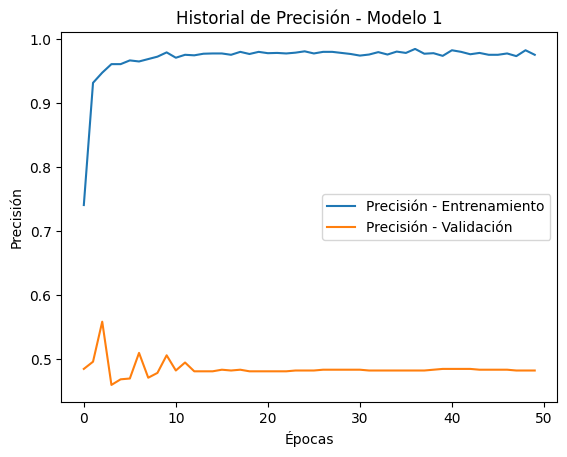

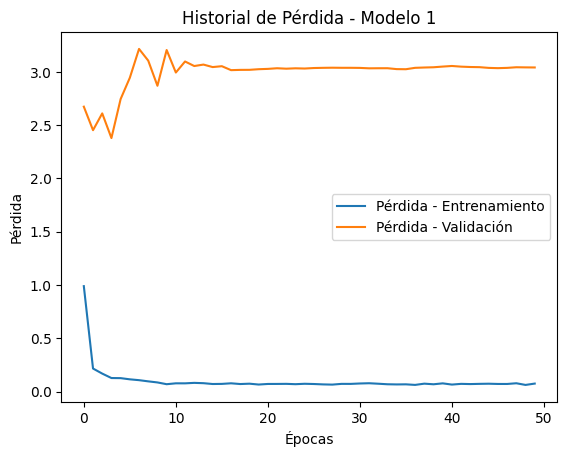


Matriz de Confusión:


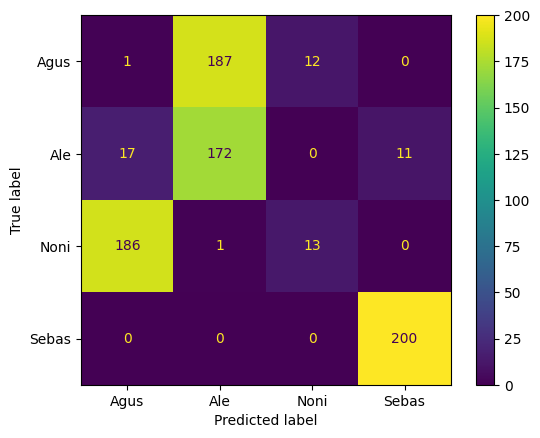



Modelo 2:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 32 neuronas, activación='tanh', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.0625
Recall: 0.2500

Graficando historial de entrenamiento...


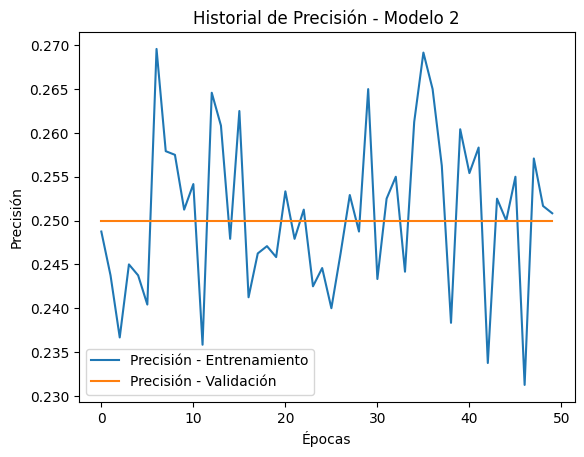

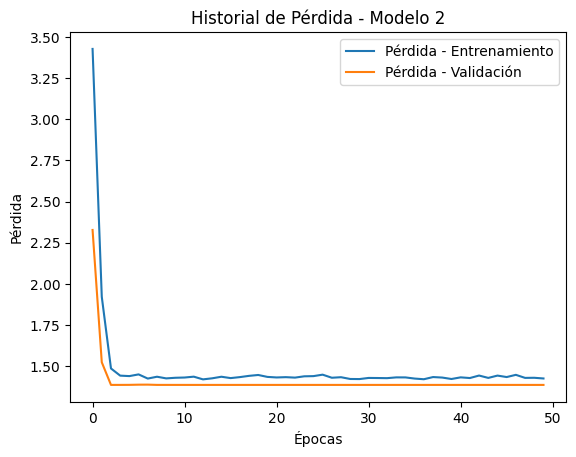


Matriz de Confusión:


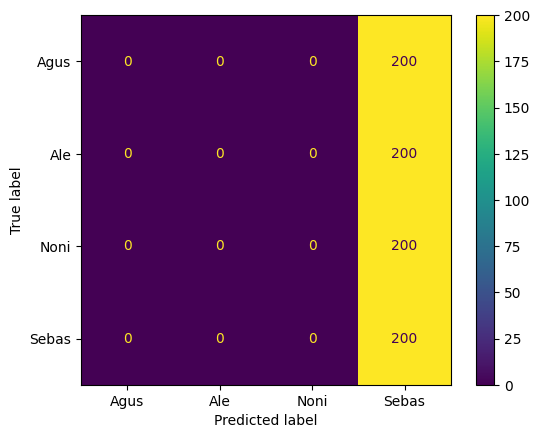



Modelo 3:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 32 neuronas, activación='leaky_relu', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5176
Recall: 0.5100

Graficando historial de entrenamiento...


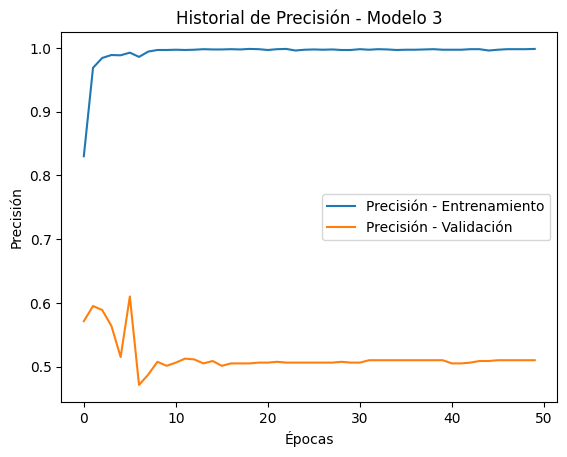

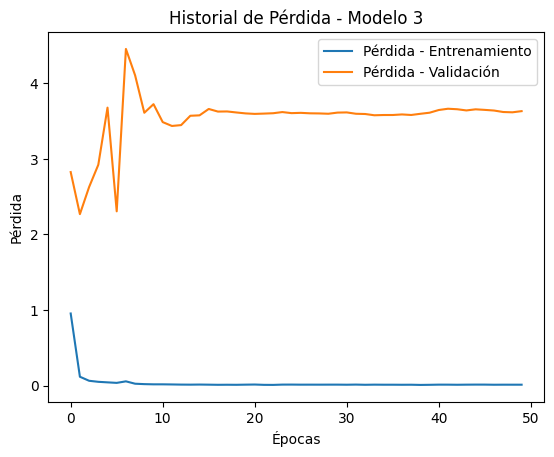


Matriz de Confusión:


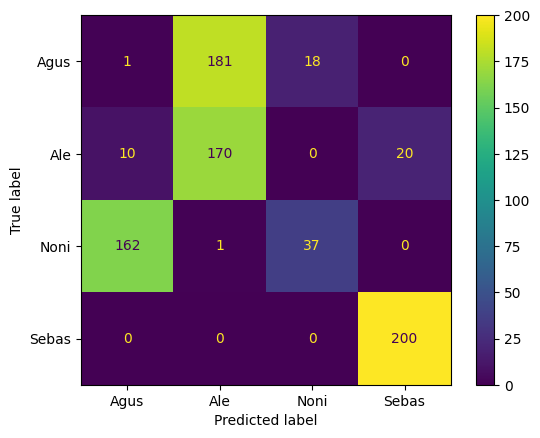



Modelo 4:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 32 neuronas, activación='swish', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5040
Recall: 0.5262

Graficando historial de entrenamiento...


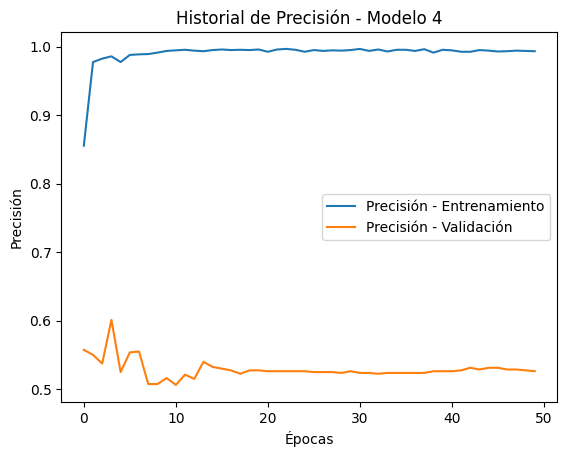

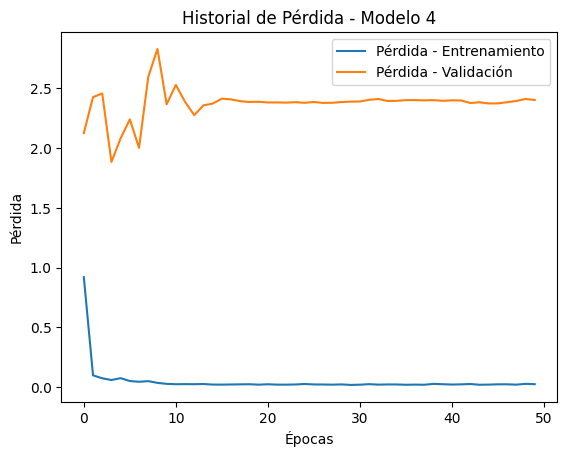


Matriz de Confusión:


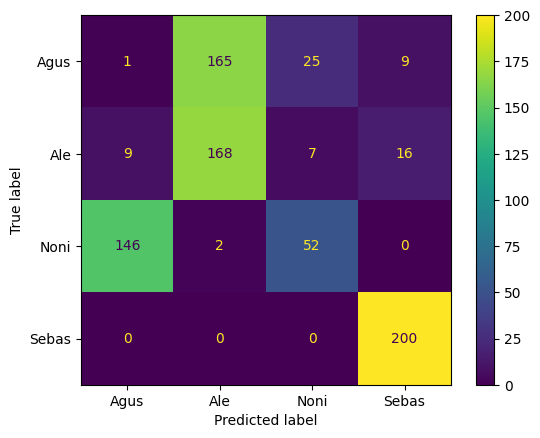



Modelo 5:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='relu', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5594
Recall: 0.5550

Graficando historial de entrenamiento...


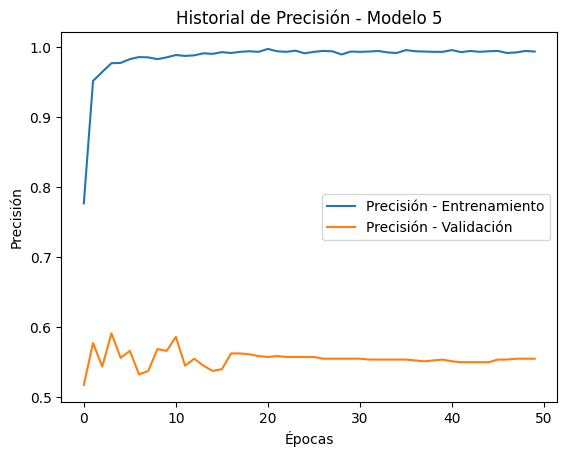

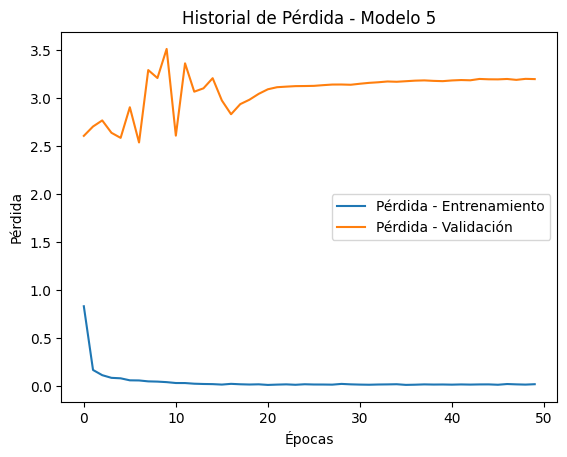


Matriz de Confusión:


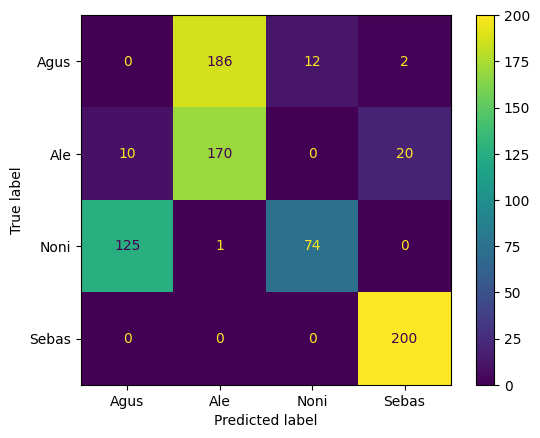



Modelo 6:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='tanh', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.0409
Recall: 0.1412

Graficando historial de entrenamiento...


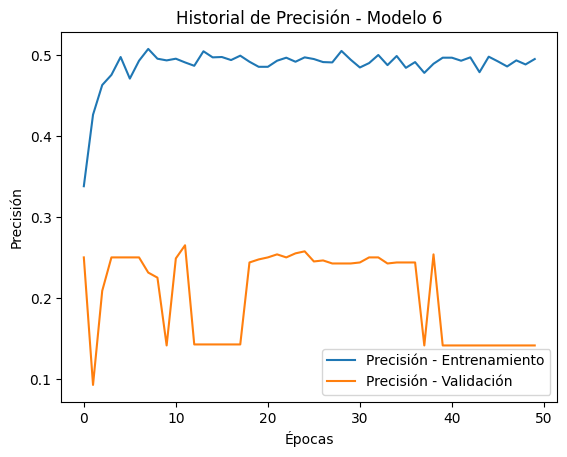

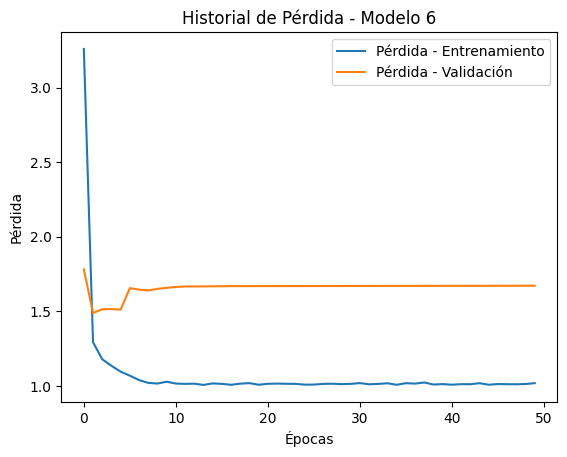


Matriz de Confusión:


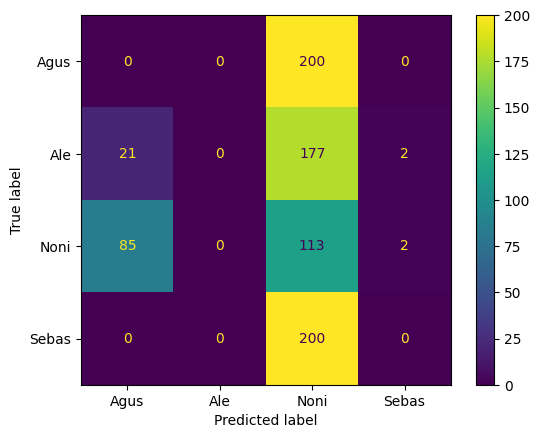



Modelo 7:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='leaky_relu', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5467
Recall: 0.5413

Graficando historial de entrenamiento...


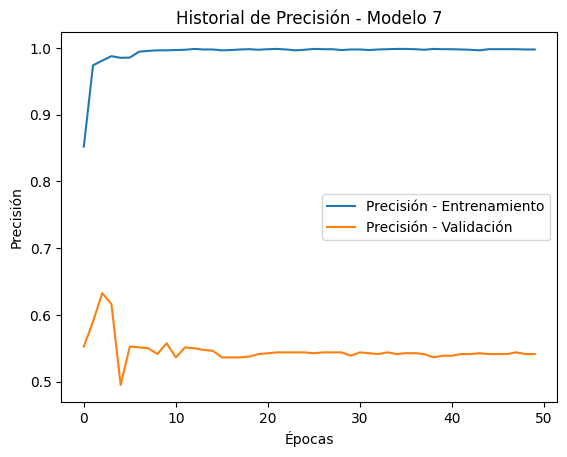

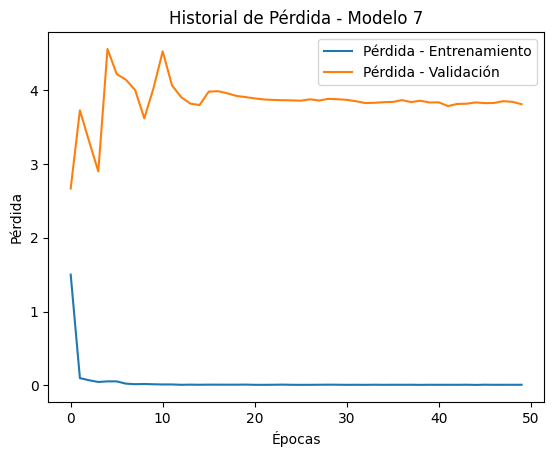


Matriz de Confusión:


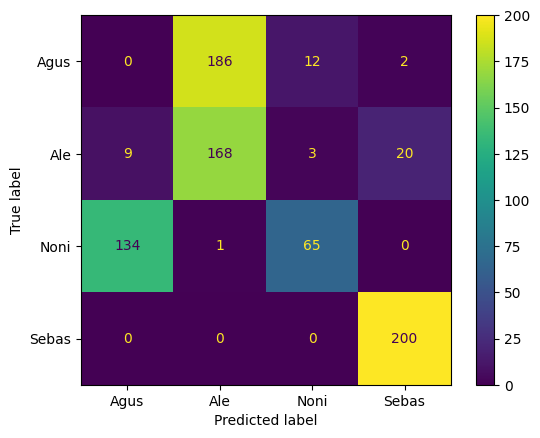



Modelo 8:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='swish', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5767
Recall: 0.5650

Graficando historial de entrenamiento...


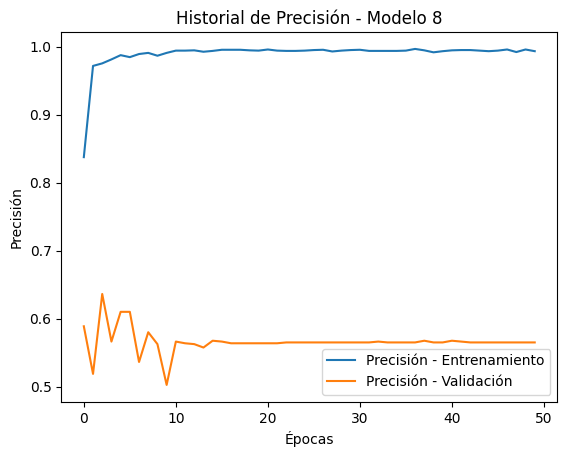

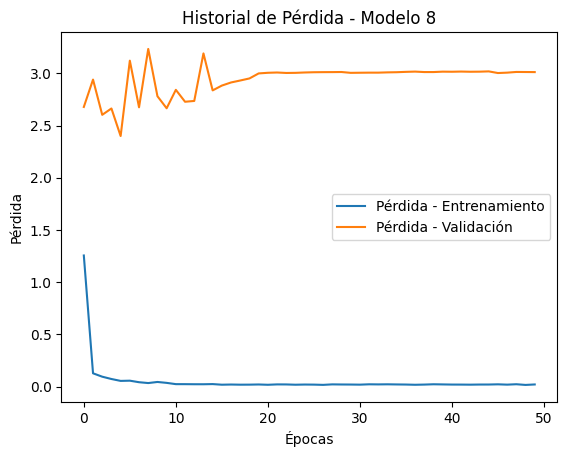


Matriz de Confusión:


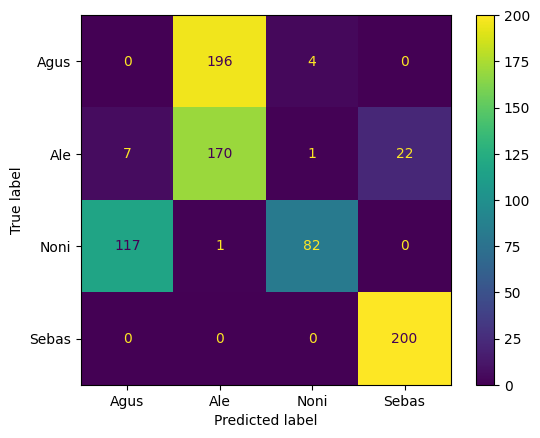



Modelo 9:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5025
Recall: 0.4938

Graficando historial de entrenamiento...


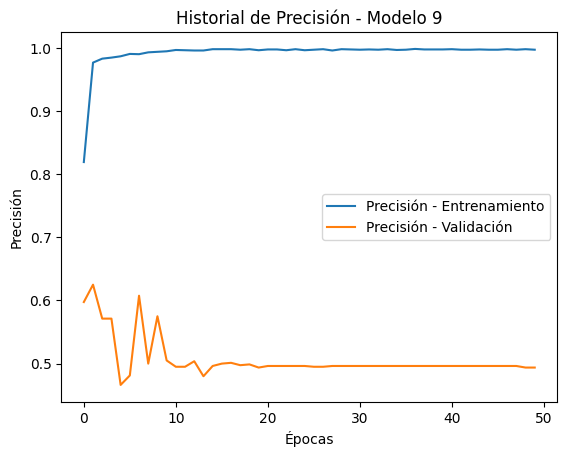

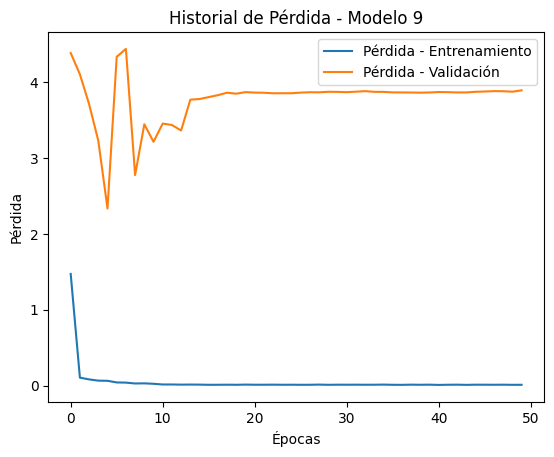


Matriz de Confusión:


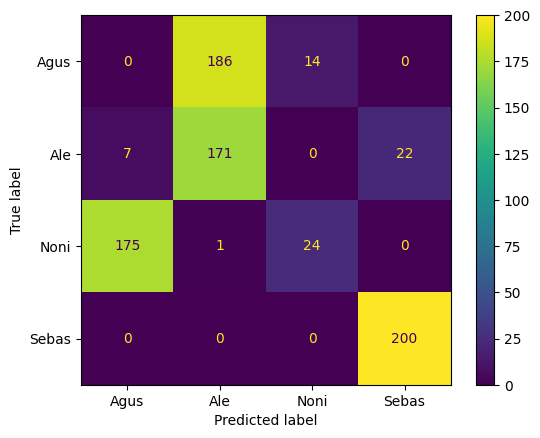



Modelo 10:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='tanh', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2691
Recall: 0.3937

Graficando historial de entrenamiento...


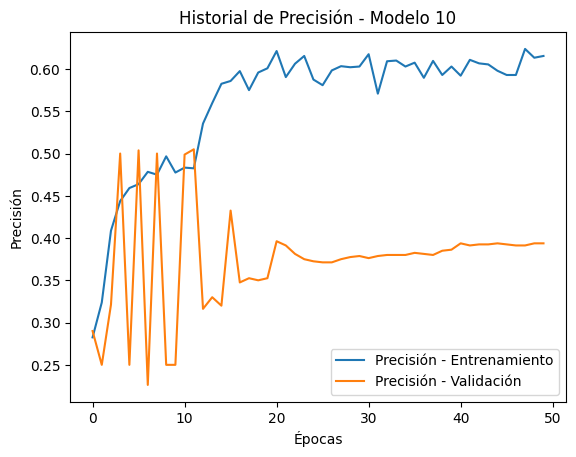

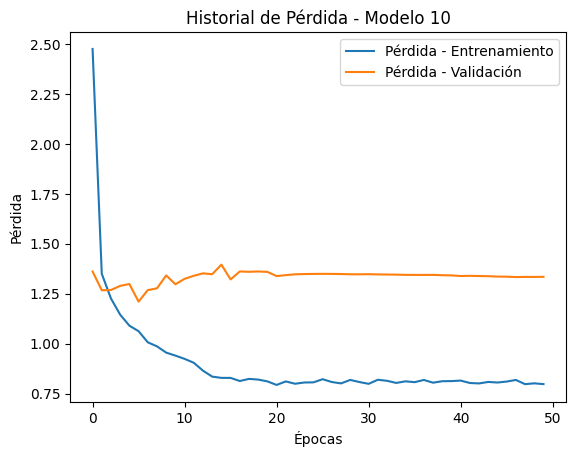


Matriz de Confusión:


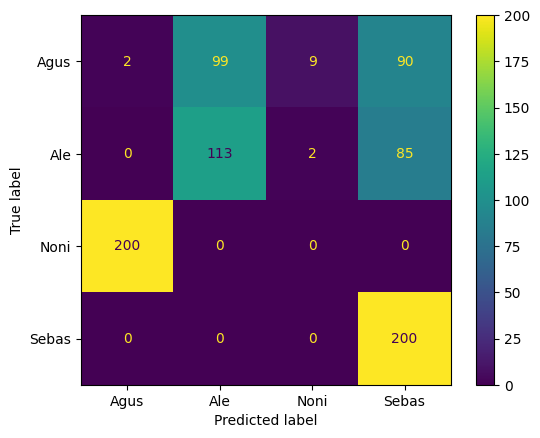



Modelo 11:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='leaky_relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5433
Recall: 0.5463

Graficando historial de entrenamiento...


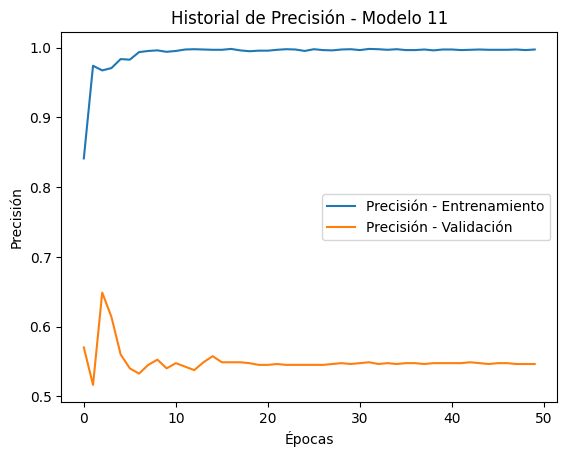

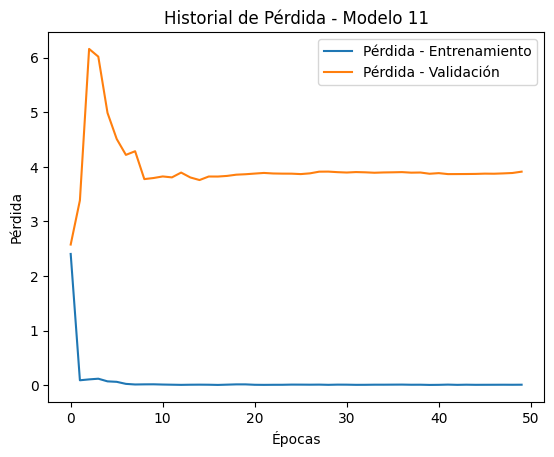


Matriz de Confusión:


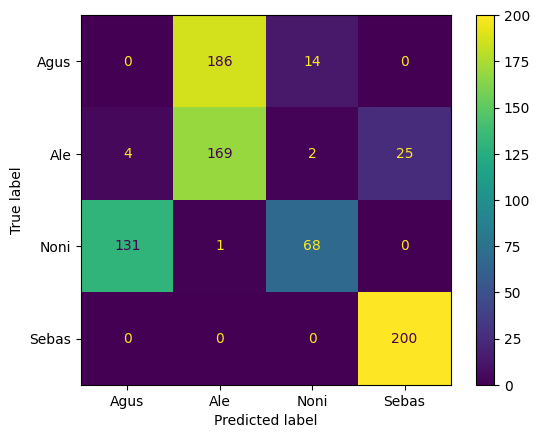



Modelo 12:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='swish', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5113
Recall: 0.5037

Graficando historial de entrenamiento...


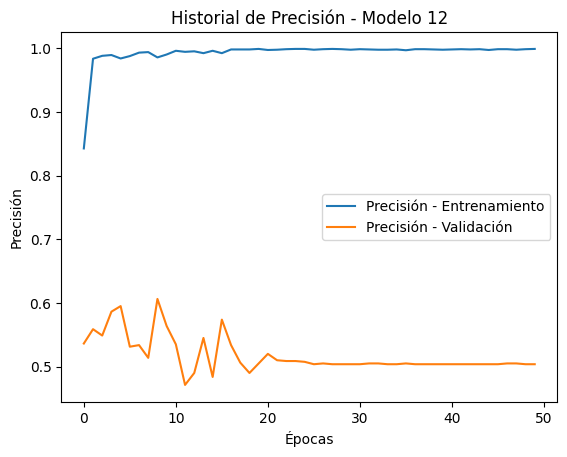

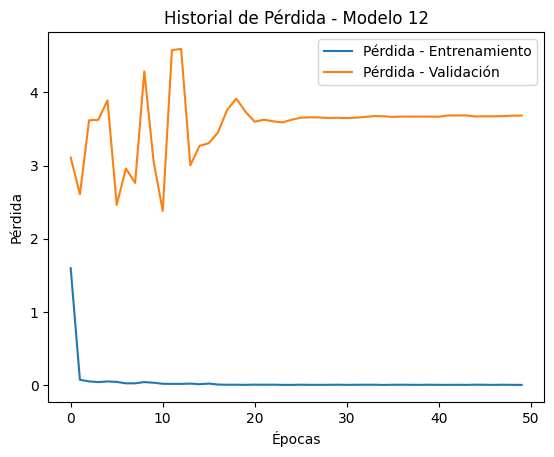


Matriz de Confusión:


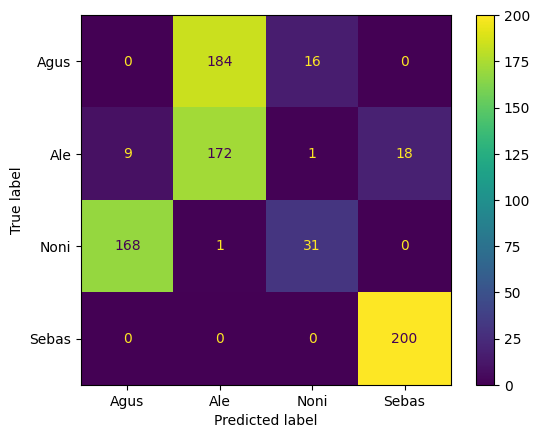



Modelo 13:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 256 neuronas, activación='relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5439
Recall: 0.5325

Graficando historial de entrenamiento...


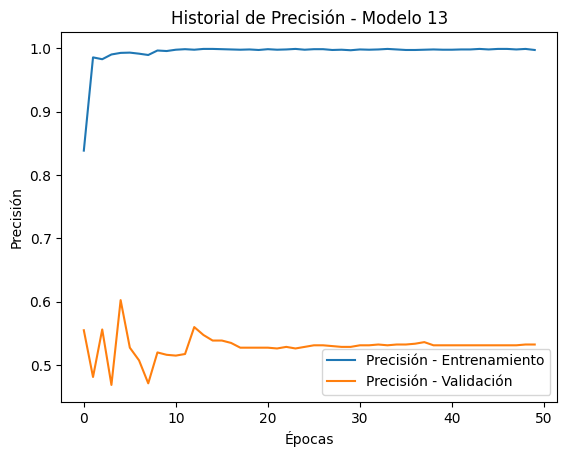

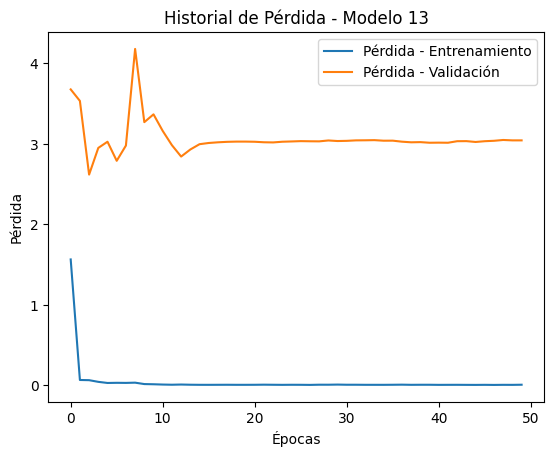


Matriz de Confusión:


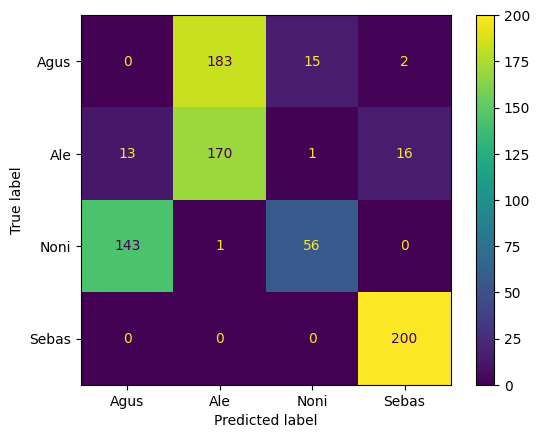



Modelo 14:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 256 neuronas, activación='tanh', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5797
Recall: 0.6212

Graficando historial de entrenamiento...


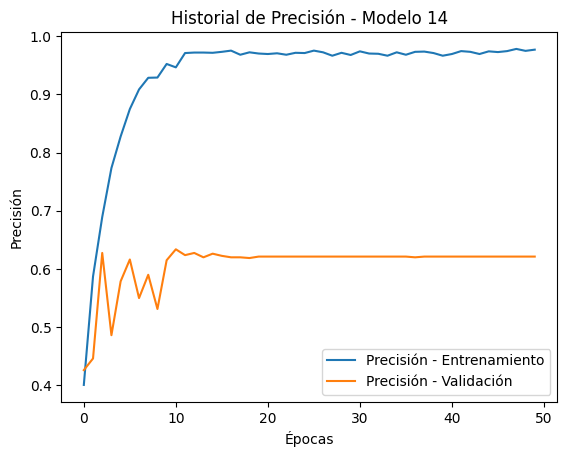

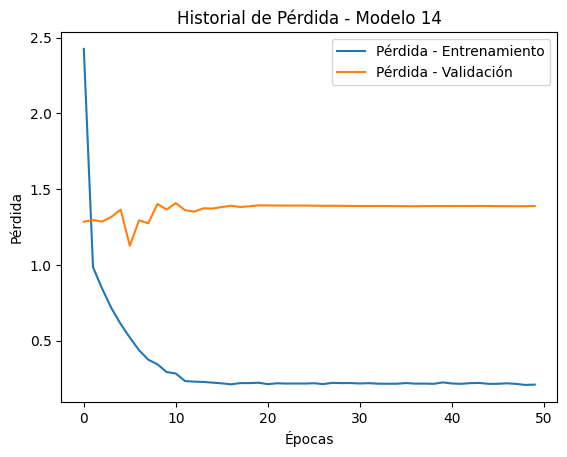


Matriz de Confusión:


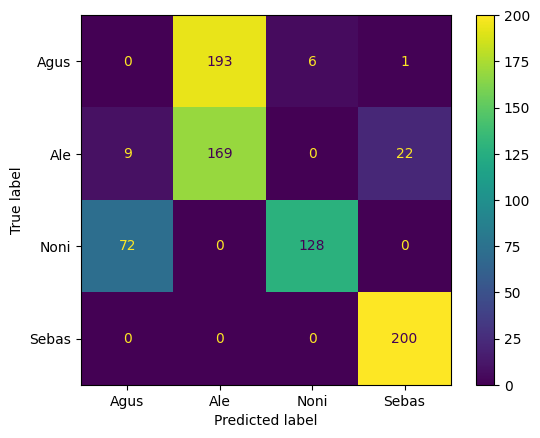



Modelo 15:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 256 neuronas, activación='leaky_relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5449
Recall: 0.5275

Graficando historial de entrenamiento...


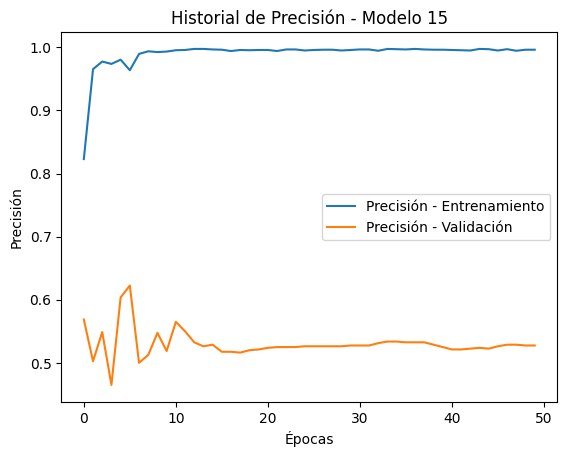

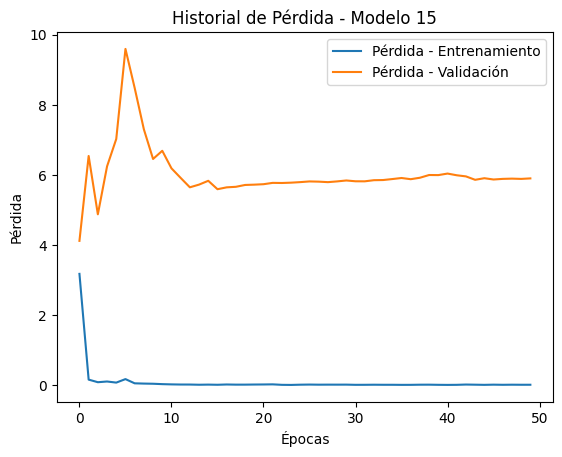


Matriz de Confusión:


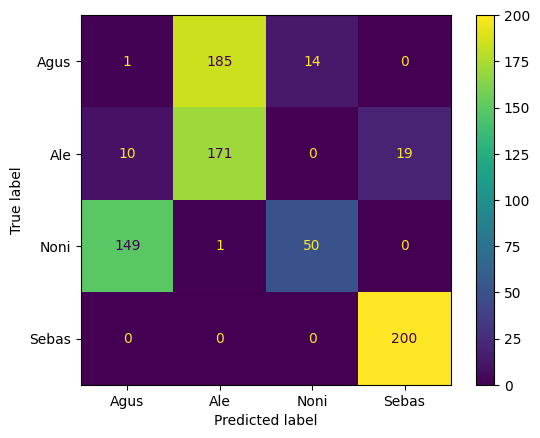



Modelo 16:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 256 neuronas, activación='swish', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5096
Recall: 0.4900

Graficando historial de entrenamiento...


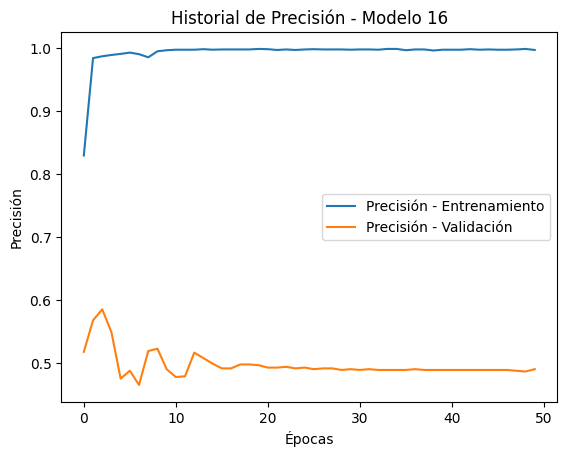

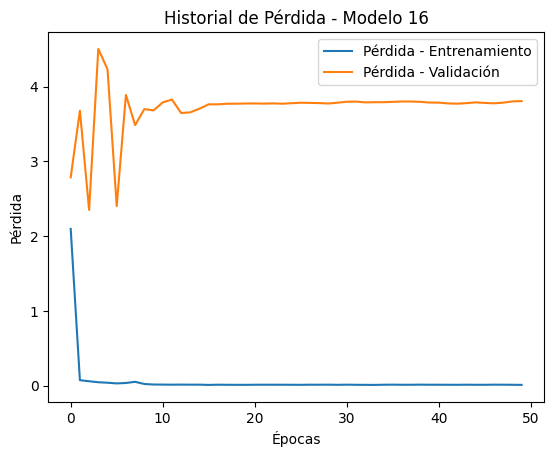


Matriz de Confusión:


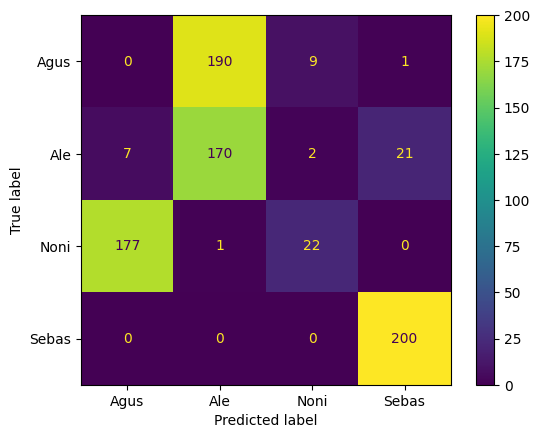



Modelo 17:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='relu', dropout=0.2
  Capa 2: 64 neuronas, activación='relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5908
Recall: 0.5837

Graficando historial de entrenamiento...


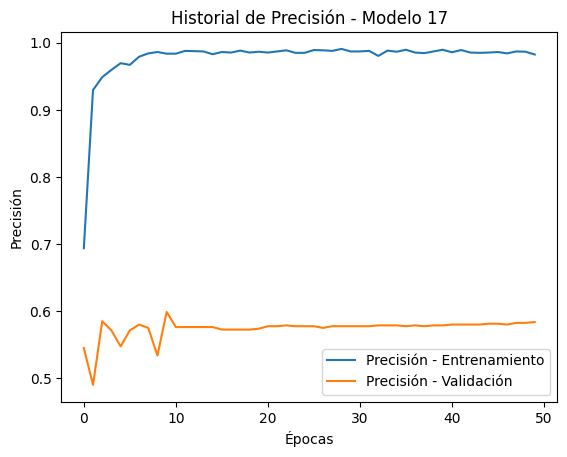

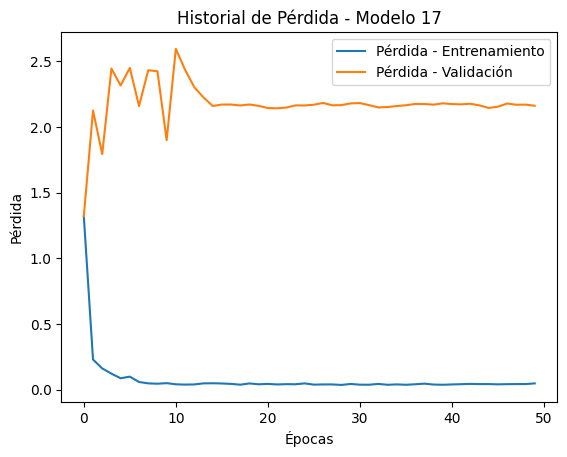


Matriz de Confusión:


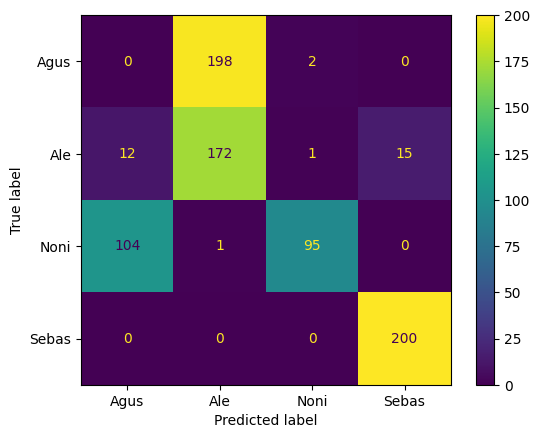



Modelo 18:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='leaky_relu', dropout=0.2
  Capa 2: 64 neuronas, activación='leaky_relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.4966
Recall: 0.5200

Graficando historial de entrenamiento...


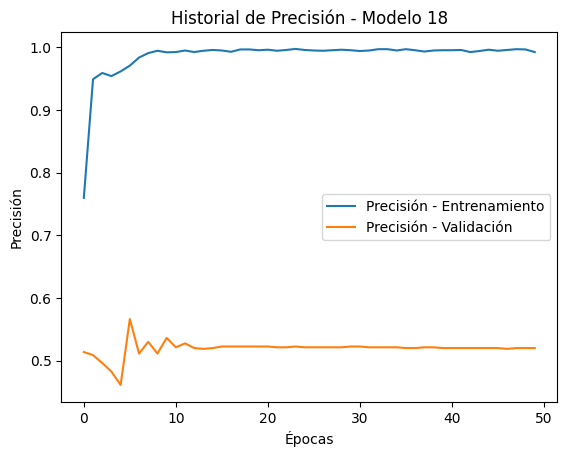

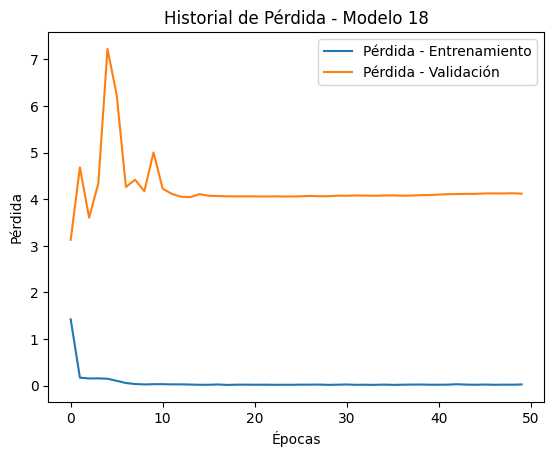


Matriz de Confusión:


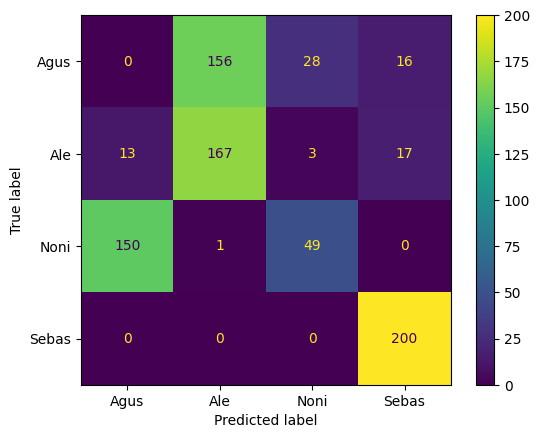



Modelo 19:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='swish', dropout=0.2
  Capa 2: 64 neuronas, activación='swish', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5362
Recall: 0.5563

Graficando historial de entrenamiento...


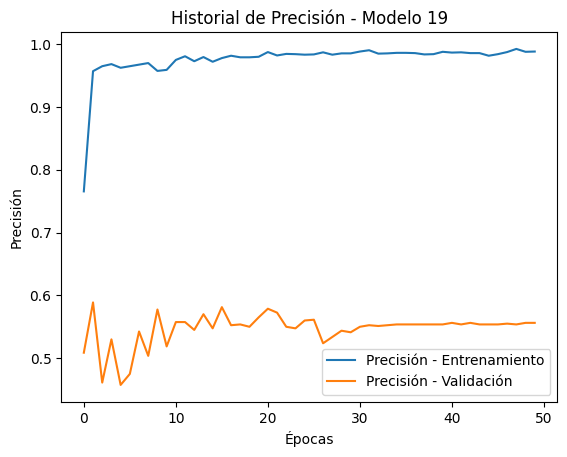

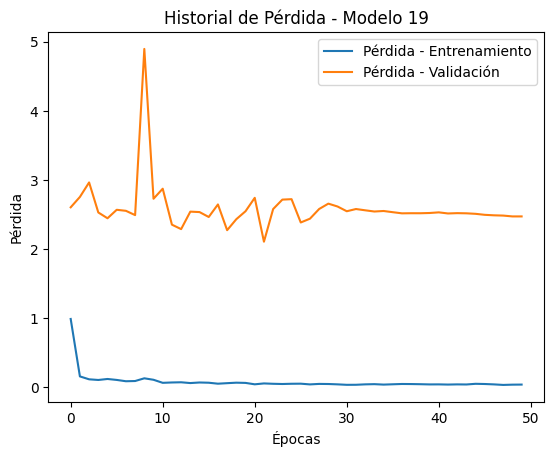


Matriz de Confusión:


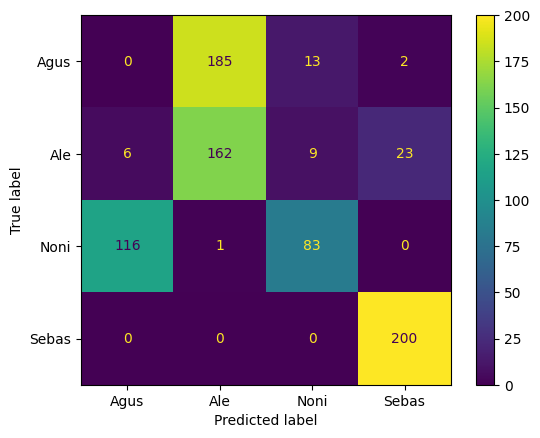



Modelo 20:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 150 neuronas, activación='relu', dropout=0.25
  Capa 2: 75 neuronas, activación='relu', dropout=0.25
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5789
Recall: 0.5950

Graficando historial de entrenamiento...


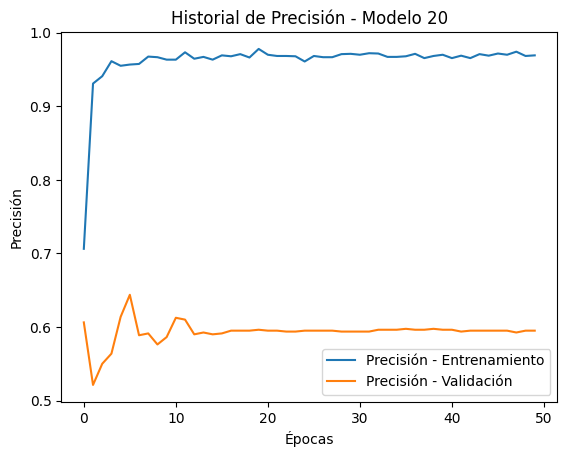

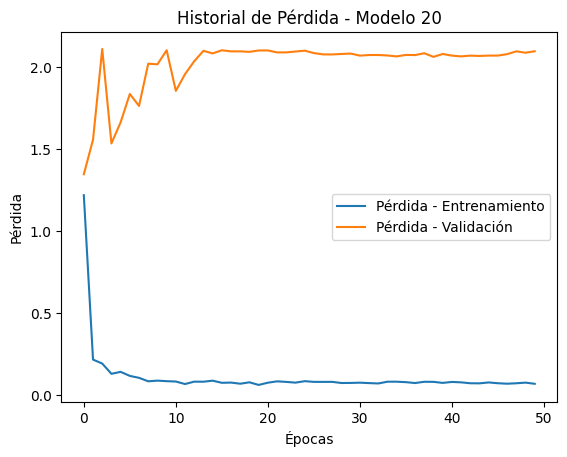


Matriz de Confusión:


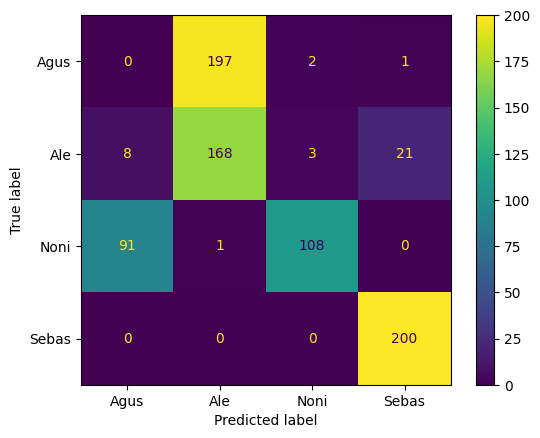



Modelo 21:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 150 neuronas, activación='leaky_relu', dropout=0.25
  Capa 2: 75 neuronas, activación='leaky_relu', dropout=0.25
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5797
Recall: 0.5537

Graficando historial de entrenamiento...


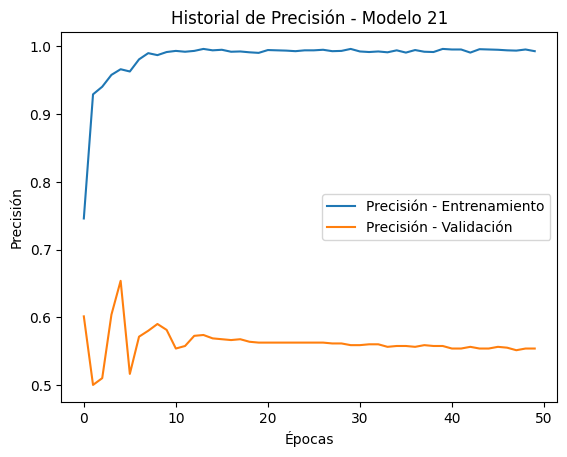

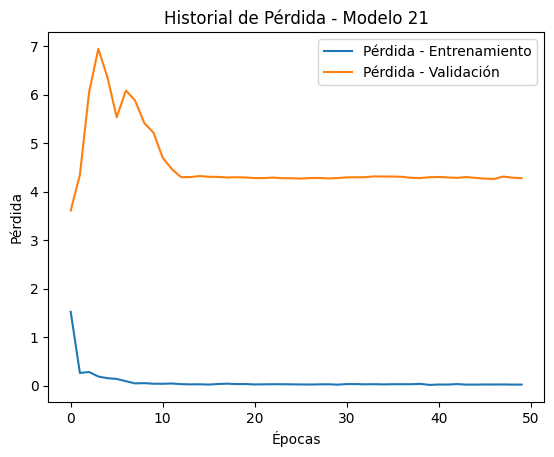


Matriz de Confusión:


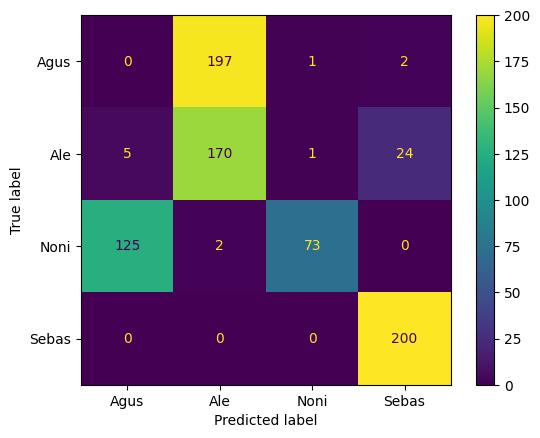



Modelo 22:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 150 neuronas, activación='swish', dropout=0.25
  Capa 2: 75 neuronas, activación='swish', dropout=0.25
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5790
Recall: 0.6050

Graficando historial de entrenamiento...


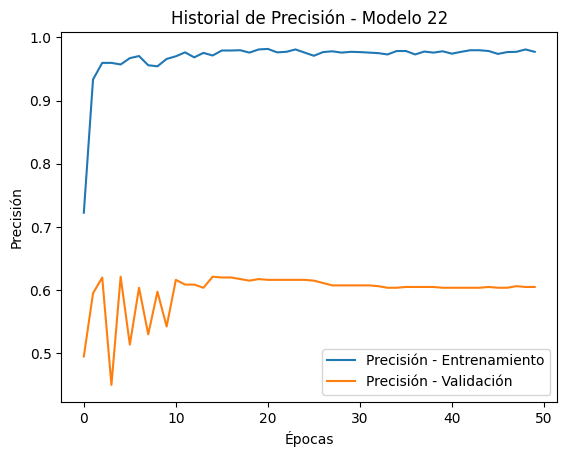

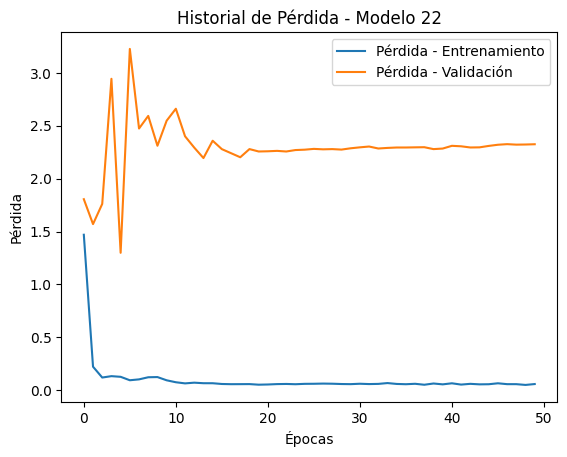


Matriz de Confusión:


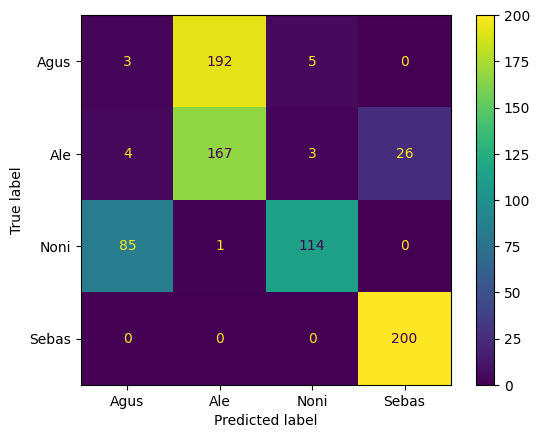



Modelo 23:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 256 neuronas, activación='relu', dropout=0.3
  Capa 2: 128 neuronas, activación='relu', dropout=0.3
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5925
Recall: 0.5813

Graficando historial de entrenamiento...


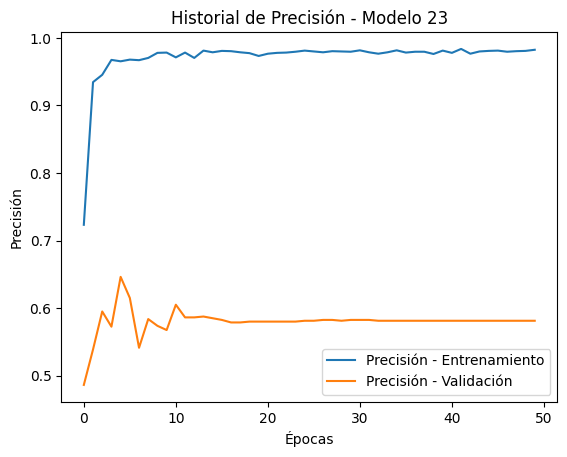

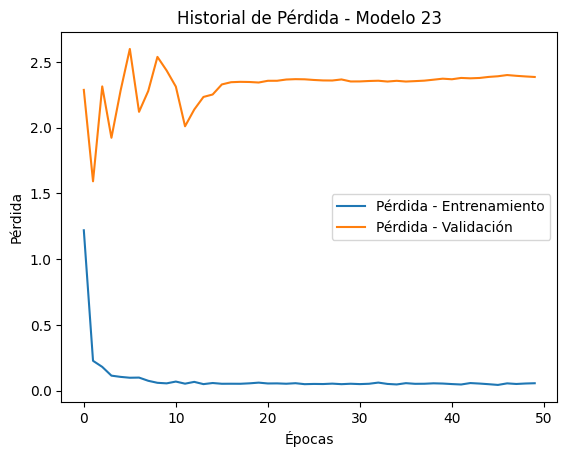


Matriz de Confusión:


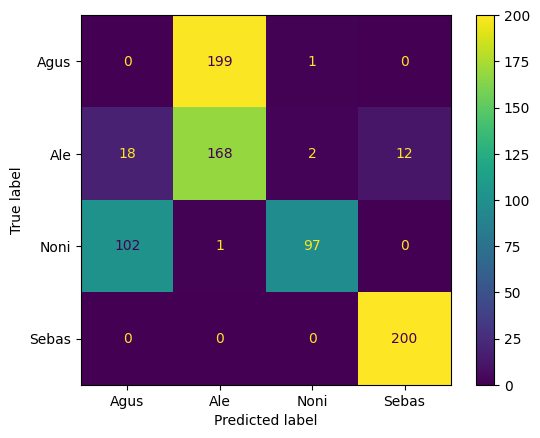



Modelo 24:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 256 neuronas, activación='leaky_relu', dropout=0.3
  Capa 2: 128 neuronas, activación='leaky_relu', dropout=0.3
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5857
Recall: 0.5750

Graficando historial de entrenamiento...


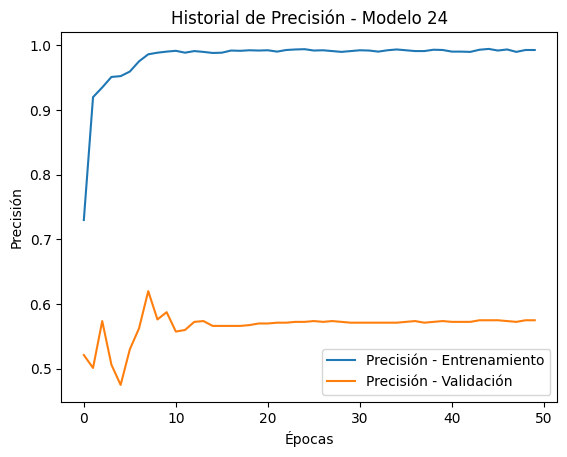

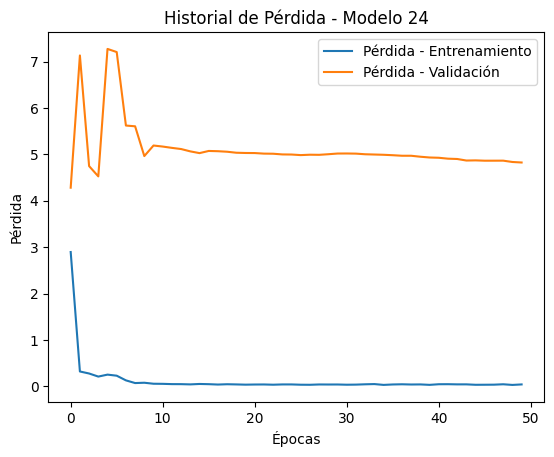


Matriz de Confusión:


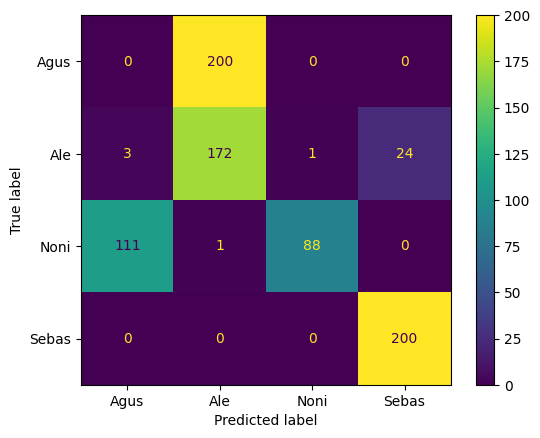



Modelo 25:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 256 neuronas, activación='swish', dropout=0.3
  Capa 2: 128 neuronas, activación='swish', dropout=0.3
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5839
Recall: 0.5862

Graficando historial de entrenamiento...


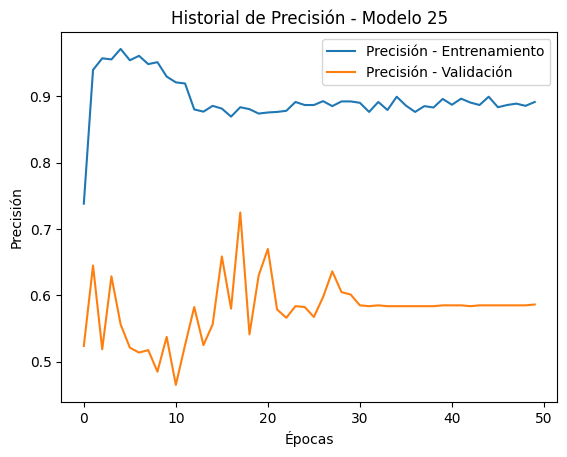

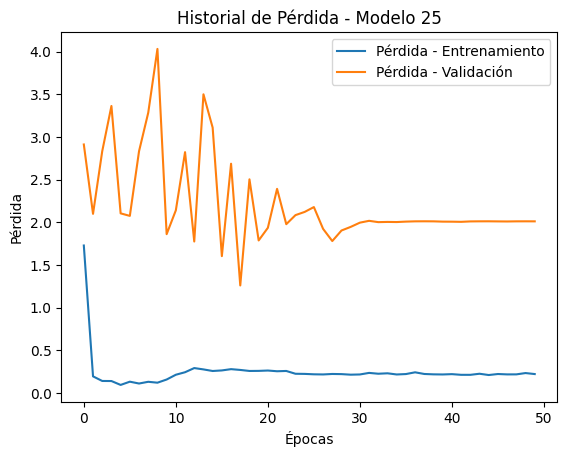


Matriz de Confusión:


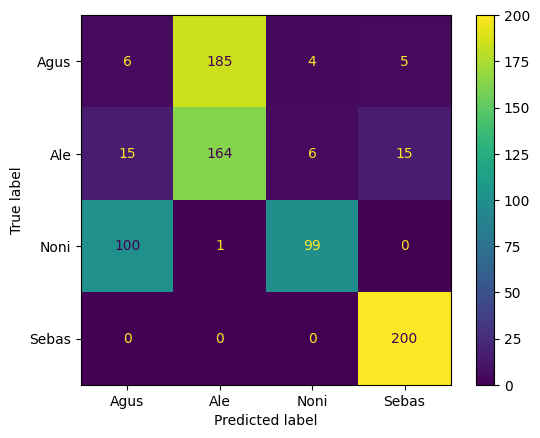



Modelo 26:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 150 neuronas, activación='relu', dropout=0.2
  Capa 2: 100 neuronas, activación='relu', dropout=0.2
  Capa 3: 50 neuronas, activación='relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5802
Recall: 0.5675

Graficando historial de entrenamiento...


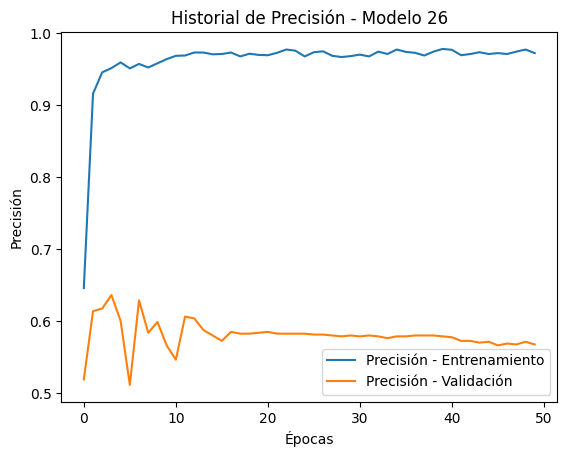

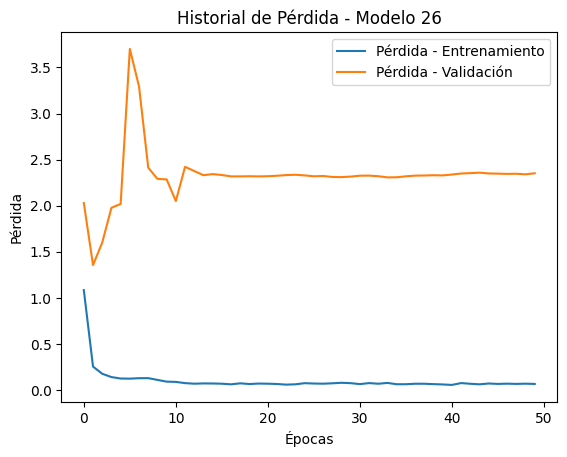


Matriz de Confusión:


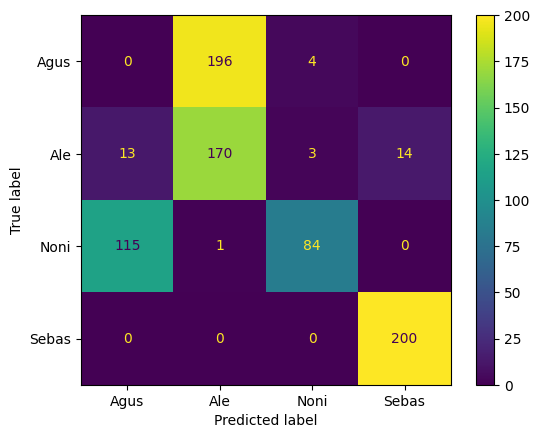



Modelo 27:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 150 neuronas, activación='leaky_relu', dropout=0.2
  Capa 2: 100 neuronas, activación='leaky_relu', dropout=0.2
  Capa 3: 50 neuronas, activación='leaky_relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5470
Recall: 0.5825

Graficando historial de entrenamiento...


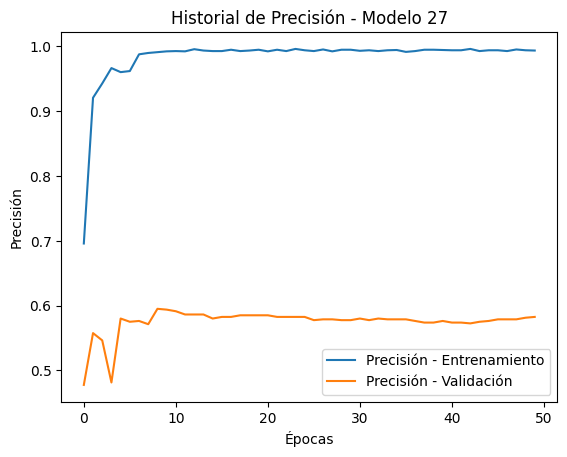

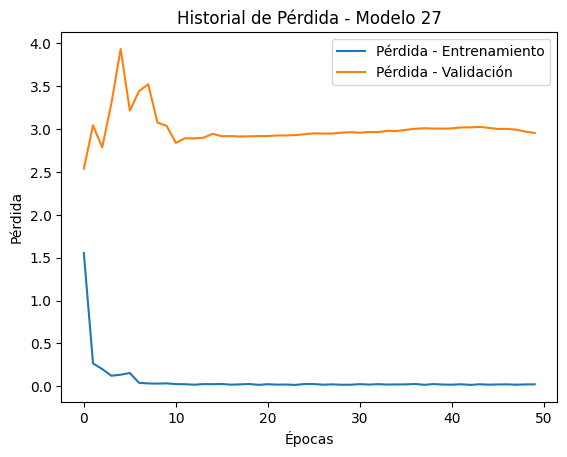


Matriz de Confusión:


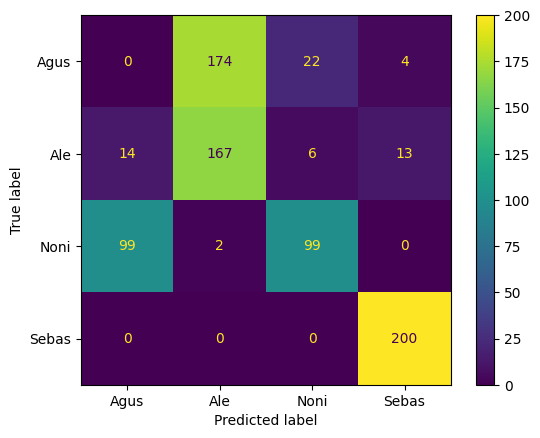



Modelo 28:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 150 neuronas, activación='swish', dropout=0.2
  Capa 2: 100 neuronas, activación='swish', dropout=0.2
  Capa 3: 50 neuronas, activación='swish', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5124
Recall: 0.4875

Graficando historial de entrenamiento...


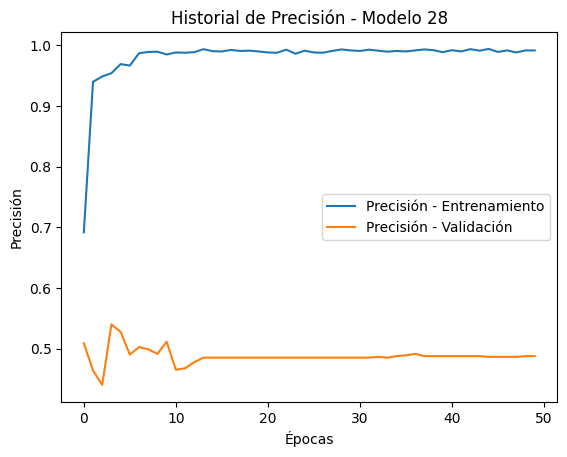

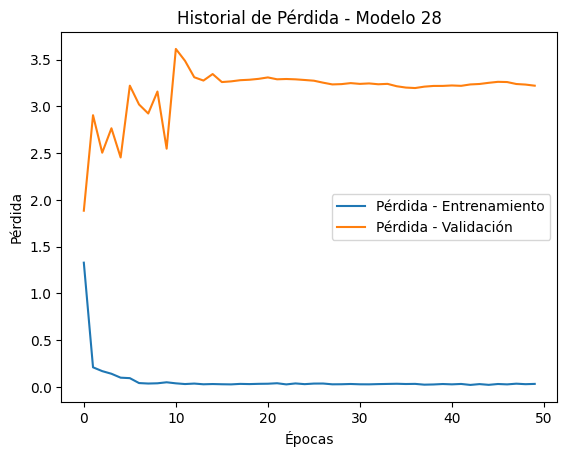


Matriz de Confusión:


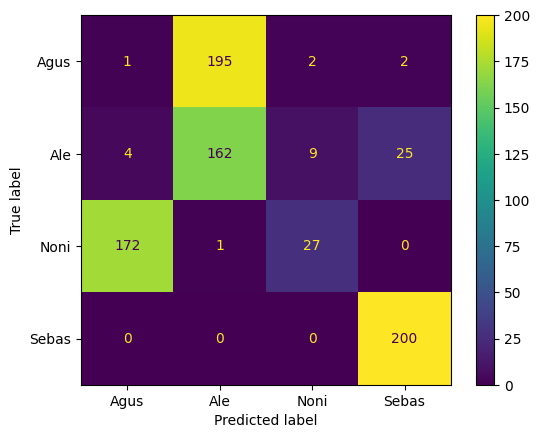



Modelo 29:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 256 neuronas, activación='relu', dropout=0.3
  Capa 2: 128 neuronas, activación='relu', dropout=0.3
  Capa 3: 64 neuronas, activación='relu', dropout=0.3
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5690
Recall: 0.5837

Graficando historial de entrenamiento...


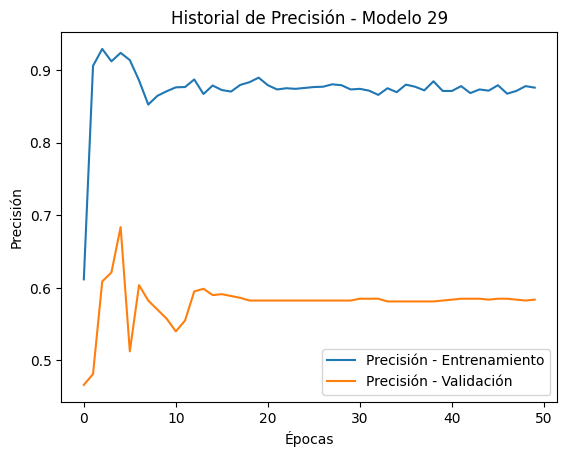

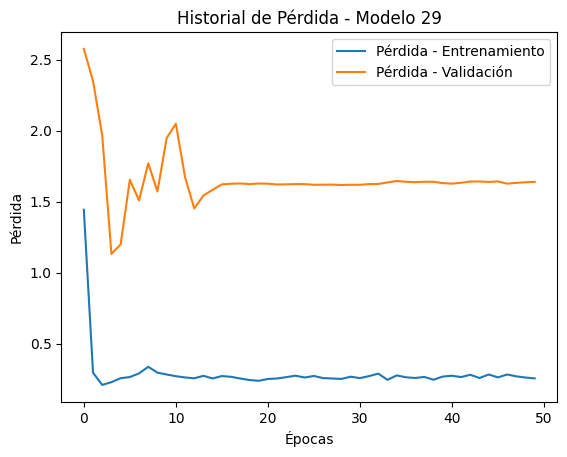


Matriz de Confusión:


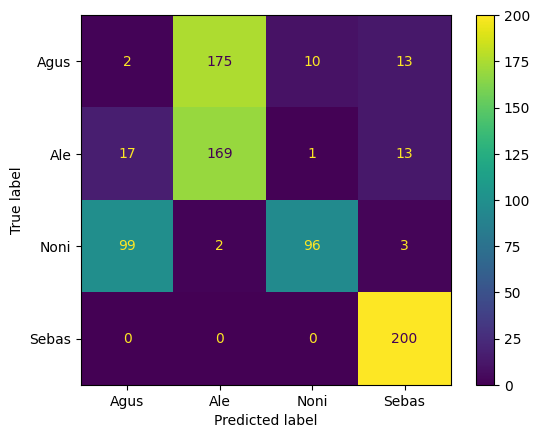



Modelo 30:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 256 neuronas, activación='leaky_relu', dropout=0.3
  Capa 2: 128 neuronas, activación='leaky_relu', dropout=0.3
  Capa 3: 64 neuronas, activación='leaky_relu', dropout=0.3
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5746
Recall: 0.5400

Graficando historial de entrenamiento...


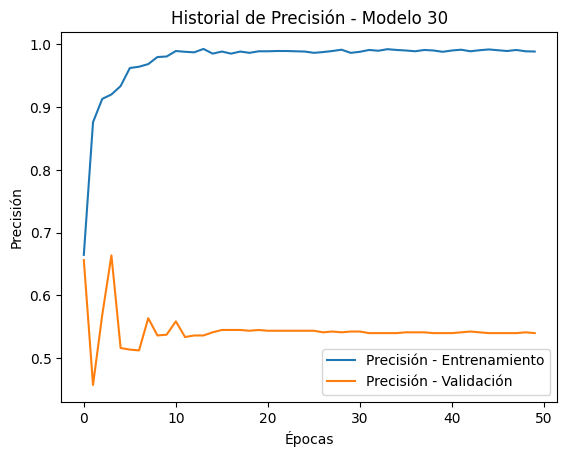

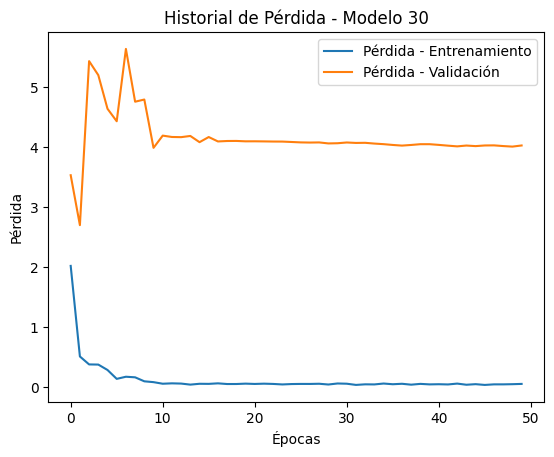


Matriz de Confusión:


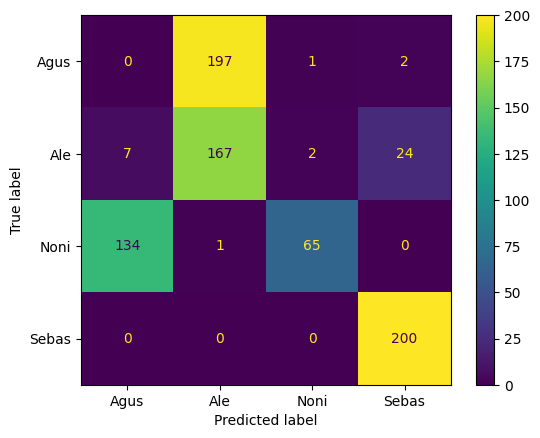



Modelo 31:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 256 neuronas, activación='swish', dropout=0.3
  Capa 2: 128 neuronas, activación='swish', dropout=0.3
  Capa 3: 64 neuronas, activación='swish', dropout=0.3
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5196
Recall: 0.5950

Graficando historial de entrenamiento...


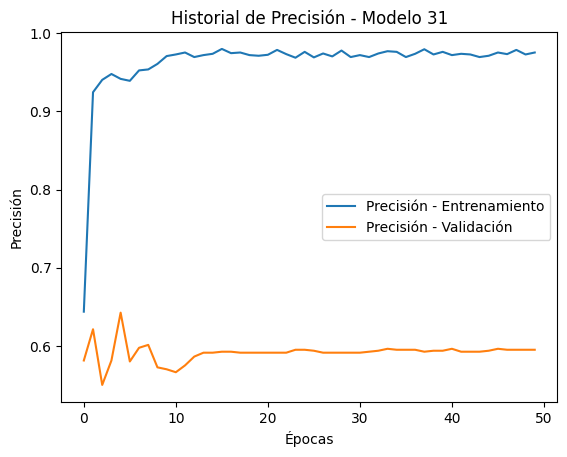

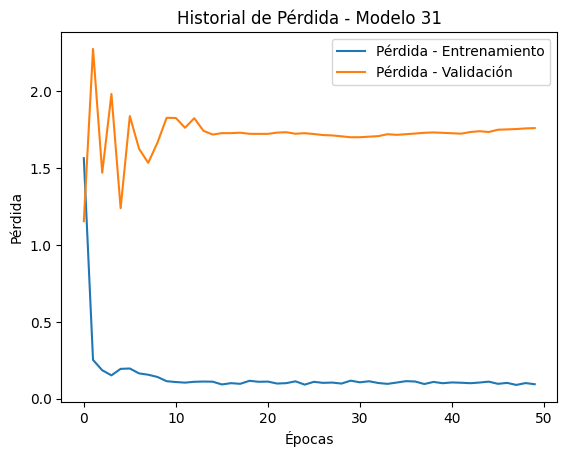


Matriz de Confusión:


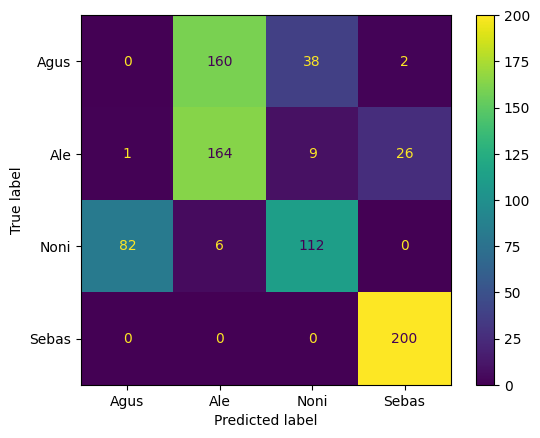



Modelo 32:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='relu', dropout=0.3
  Capa 2: 256 neuronas, activación='relu', dropout=0.3
  Capa 3: 128 neuronas, activación='relu', dropout=0.3
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5222
Recall: 0.4962

Graficando historial de entrenamiento...


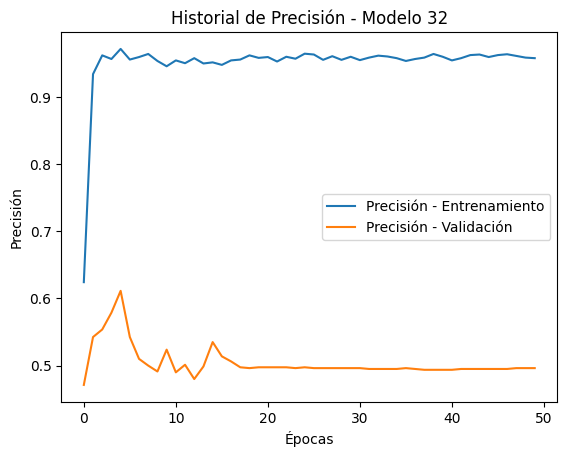

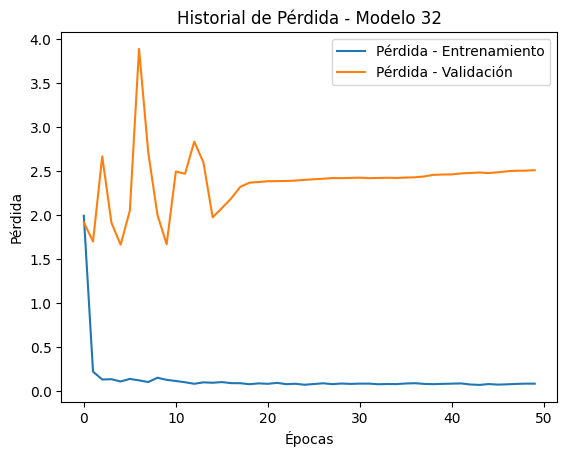


Matriz de Confusión:


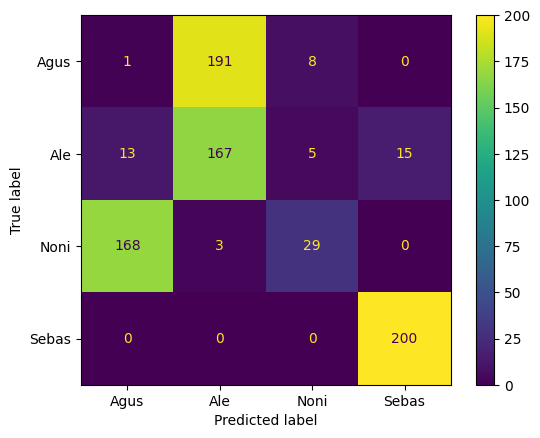



Modelo 33:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='leaky_relu', dropout=0.3
  Capa 2: 256 neuronas, activación='leaky_relu', dropout=0.3
  Capa 3: 128 neuronas, activación='leaky_relu', dropout=0.3
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5883
Recall: 0.5650

Graficando historial de entrenamiento...


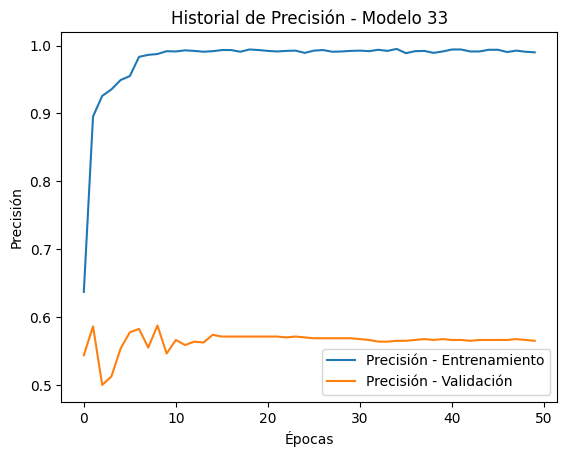

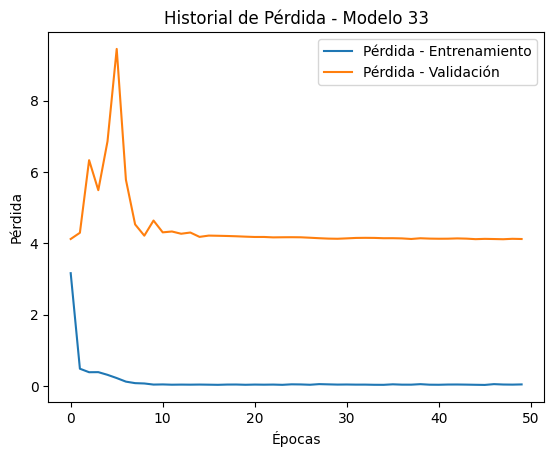


Matriz de Confusión:


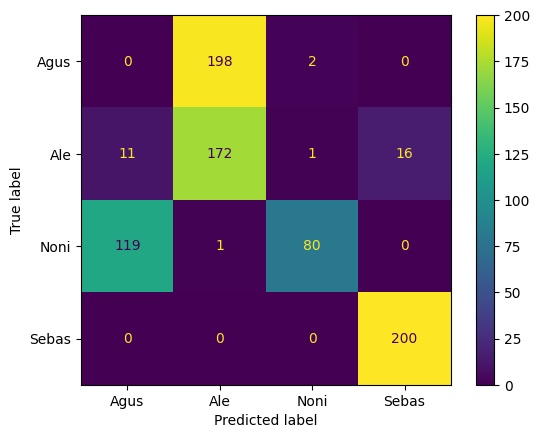



Modelo 34:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='swish', dropout=0.3
  Capa 2: 256 neuronas, activación='swish', dropout=0.3
  Capa 3: 128 neuronas, activación='swish', dropout=0.3
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.6025
Recall: 0.5400

Graficando historial de entrenamiento...


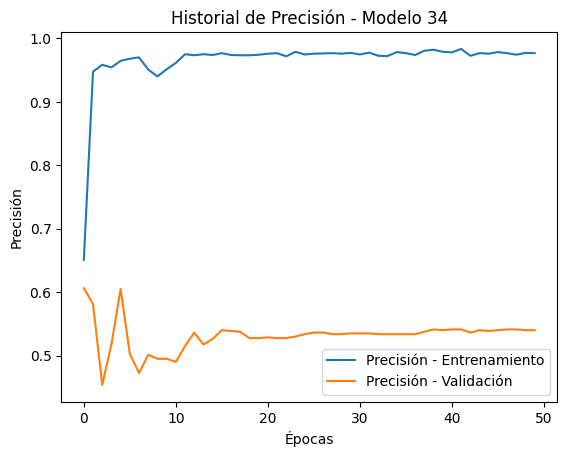

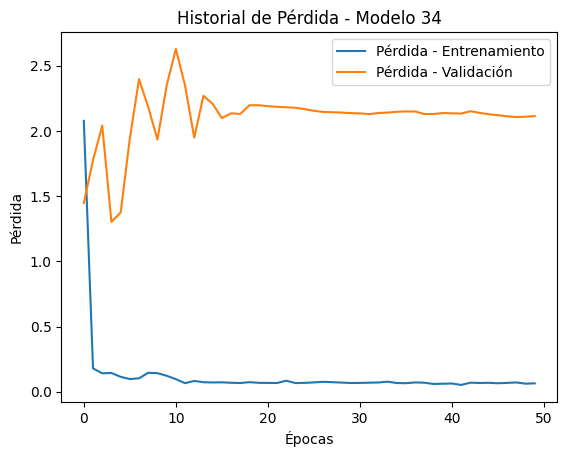


Matriz de Confusión:


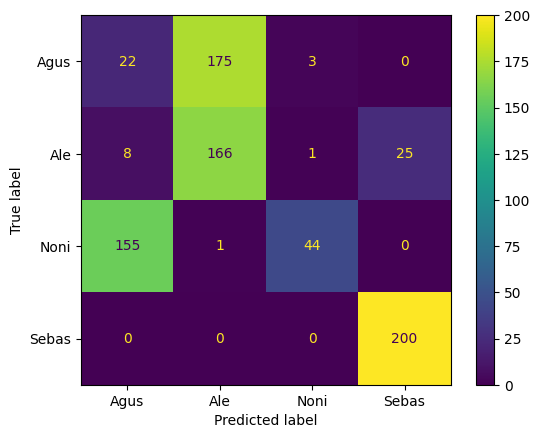

In [74]:
def mostrar_configuracion(configuracion):
    salida = []
    salida.append("Capas Ocultas:")
    for i, capa in enumerate(configuracion["capas_ocultas"]):
        salida.append(f"  Capa {i + 1}: {capa['neuronas']} neuronas, activación='{capa['activation']}', dropout={capa.get('dropout', 0)}")
    salida.append(f"Learning Rate: {configuracion['learning_rate']}")
    salida.append(f"Factor de Reducción: {configuracion['factor_reduccion']}")
    salida.append(f"Salida: {configuracion['output']['neuronas']} neuronas, activación='{configuracion['output']['activation']}'")
    return "\n".join(salida)

def mostrar_todo_dataframe(df, labels):
    for index, fila in df.iterrows():
        print(f"Modelo {index + 1}:")
        print("-" * 40)
        
        print("Configuración del modelo:")
        print(mostrar_configuracion(fila["configuracion"]))
        
        print("\nMétricas del modelo:")
        print(f"Precisión: {fila['precision']:.4f}")
        print(f"Recall: {fila['recall']:.4f}")
        
        historial = fila["historial"]
        print("\nGraficando historial de entrenamiento...")
        plt.plot(historial["accuracy"], label="Precisión - Entrenamiento")
        plt.plot(historial["val_accuracy"], label="Precisión - Validación")
        plt.title(f"Historial de Precisión - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Precisión")
        plt.legend()
        plt.show()

        plt.plot(historial["loss"], label="Pérdida - Entrenamiento")
        plt.plot(historial["val_loss"], label="Pérdida - Validación")
        plt.title(f"Historial de Pérdida - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida")
        plt.legend()
        plt.show()

        print("\nMatriz de Confusión:")
        cm_display = ConfusionMatrixDisplay(fila["matriz_confusion"], display_labels=labels)
        cm_display.plot()
        plt.show()

        print("\n" + "=" * 50 + "\n")

mostrar_todo_dataframe(df_resultados, labels=labels)
